In [1]:
%reset -f

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'
plt.rcParams['figure.figsize'] = (10.0, 6.0)

In [3]:
import scipy.stats

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as D

In [5]:
import collections

In [6]:
import pickle

In [7]:
import bridson

In [8]:
import sklearn.preprocessing
import sklearn.model_selection

In [9]:
import uproot
uproot.default_library = "np"

In [10]:
import os.path

In [11]:
import logging
logging.basicConfig(level=logging.INFO)

In [12]:
np.set_printoptions(precision=4, suppress=True)

In [13]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=1)

In [14]:
def to_numpy(t):
    return t.detach().cpu().numpy()
def to_numpy_(*t_):
    return (to_numpy(t) for t in t_)
def from_numpy(t, dtype=torch.float, device=device):
    return torch.as_tensor(t, dtype=dtype, device=device)
def from_numpy_(*t_, dtype=torch.float, device=device):
    return (from_numpy(t, dtype=dtype, device=device) for t in t_)
def as_numpy(f, dtype=torch.float, device=device):
    return lambda *x: to_numpy(f(*from_numpy_(*x, dtype=dtype, device=device)))
def as_numpy_(f, dtype=torch.float, device=device):
    return lambda *x: to_numpy_(*f(*from_numpy_(*x, dtype=dtype, device=device)))

In [15]:
class Lambda(torch.nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn
    def forward(self, x):
        return self.fn(x)

In [16]:
def clone_model(model, force_eval=True, set_to_none=True):
    if force_eval:
        model.eval()
    model.zero_grad(set_to_none=set_to_none)
    return pickle.loads(pickle.dumps(model))

### Data

In [17]:
class DataFile(object):
    def __init__(self, path, name, aliases={}):
        self.path = path
        self.name = name
        self.aliases = aliases
        self.raw = uproot.open(self.path)
    def features(self):
        return sorted(list(set(list(self.raw.keys()) + list(self.aliases.keys()))))
    def true_features(self):
        return [name for name in self.features() if "TRUE" in name]
    def __len__(self):
        return self.raw.num_entries
    def __item__(self, name):
        return self.raw[name].array(library="np")
    def get(self, features, aliases={}):
        res = self.raw.arrays(features, aliases=(self.aliases|aliases), library="np")
        array = np.empty((self.raw.num_entries, len(features)), dtype=float)
        for i, feature in enumerate(features):
            array[:,i] = res[feature]
        return array

In [18]:
channel_names = [
    r"B⁺→K⁺ee",
    r"B⁺→K⁺J/ψ(→ee)",
    r"B⁺→K⁺ψ(2S)(→ee)",
    r"D⁺→π⁺φ(→ee)",
]

In [19]:
tree_names_nohits = [
    "RapidSim/B2Kee_tree.root:DecayTree;29",
    "RapidSim/B2KJpsi2ee_tree.root:DecayTree;36",
    "RapidSim/B2Kpsi2s2ee_tree.root:DecayTree;37",
    "RapidSim/D2phipi2ee_tree.root:DecayTree;31",
]

In [20]:
tree_names_hits = [
    "RapidSim/B2Kee_tree-2Dhits.root:DecayTree;27",
    "RapidSim/B2KJpsi2ee_tree-2Dhits.root:DecayTree;34",
    "RapidSim/B2Kpsi2s2ee_tree-2Dhits.root:DecayTree;35",
    "RapidSim/D2phipi2ee_tree-2Dhits.root:DecayTree;30",
]

In [21]:
basedir = os.path.expanduser("~/2021/")
files = [DataFile(os.path.join(basedir, path), name) for path, name in zip(tree_names_nohits, channel_names)]

In [22]:
files[3].aliases = {
    'B_FD': "D_FD",
    'B_FD_TRUE': "D_FD_TRUE",
}

In [23]:
def common_features(fs):
    return sorted(set.intersection(*[set(f.true_features()) for f in fs]))
common_features(files)

['B_FD_TRUE',
 'angle_ee_TRUE',
 'em_ET_TRUE',
 'em_E_TRUE',
 'em_IP_TRUE',
 'em_PT_TRUE',
 'em_PT_TRUE_',
 'em_PX_TRUE',
 'em_PY_TRUE',
 'em_PZ_TRUE',
 'em_P_TRUE',
 'em_SIGMAIP_TRUE',
 'em_eta_TRUE',
 'em_origX_TRUE',
 'em_origY_TRUE',
 'em_origZ_TRUE',
 'em_phi_TRUE',
 'ep_ET_TRUE',
 'ep_E_TRUE',
 'ep_IP_TRUE',
 'ep_PT_TRUE',
 'ep_PT_TRUE_',
 'ep_PX_TRUE',
 'ep_PY_TRUE',
 'ep_PZ_TRUE',
 'ep_P_TRUE',
 'ep_SIGMAIP_TRUE',
 'ep_eta_TRUE',
 'ep_origX_TRUE',
 'ep_origY_TRUE',
 'ep_origZ_TRUE',
 'ep_phi_TRUE',
 'q2_TRUE']

### Event selection

In [24]:
class SelectedData(object):
    def __init__(self, datafile, selector):
        assert selector.shape == (len(datafile), )
        self.datafile = datafile
        self.index = np.asarray(selector, dtype=bool)
        self.size = np.sum(self.index)
    def name(self):
        return self.datafile.name
    def get(self, features, aliases={}):
        return self.datafile.get(features, aliases=aliases)[self.index]
    def true_features(self):
        return self.datafile.true_features()
    def features(self):
        return self.datafile.features()
    def __len__(self):
        return self.size

In [25]:
def split(selected, **options):
    selector = selected.index
    arr = np.arange(len(selector))[selector]
    train_index, test_index = sklearn.model_selection.train_test_split(arr, **options)
    train_selector = np.zeros_like(selector, dtype=bool)
    test_selector = np.zeros_like(selector, dtype=bool)
    train_selector[train_index] = True
    test_selector[test_index] = True
    train = SelectedData(selected.datafile, train_selector)
    test = SelectedData(selected.datafile, test_selector)
    return train, test

In [26]:
def join_and(*conditions):
    return "&".join(["(%s)"%condition for condition in conditions])
def q2_range(v1, v2, true=True):
    feature = "q2_TRUE" if true else "q2"
    return join_and("%s > %g" % (feature, v1), "%s < %g" % (feature, v2))

In [27]:
def e_selectors(true=True):
    q_Kll_selector = q2_range(1.1, 6.0, true)
    q_Jpsi_e_selector = q2_range(6.0, 12.96, true)
    q_psi2S_e_selector = q2_range(9.82, 16.40, true)
    selectors = [
        q_Kll_selector,
        q_Jpsi_e_selector,
        q_psi2S_e_selector,
        "True",
    ]
    return selectors

#q_Jpsi_mu_selector = q2_range(8.68, 10.09)
#q_psi2S_mu_selector = q2_range(12.5, 14.2)

In [28]:
selectors_true = e_selectors(True)
selectors_notrue = e_selectors(False)

In [29]:
selected_true = [SelectedData(f, f.get([selector])[:,0]) for f, selector in zip(files, selectors_true)]
selected_notrue = [SelectedData(f, f.get([selector])[:,0]) for f, selector in zip(files, selectors_notrue)]

In [30]:
splitted_true = [split(f, shuffle=True, test_size=0.2) for f in selected_true]
train_ds_true = [x[0] for x in splitted_true]
test_ds_true = [x[1] for x in splitted_true]

In [31]:
splitted_notrue = [split(f, shuffle=True, test_size=0.2) for f in selected_notrue]
train_ds_notrue = [x[0] for x in splitted_notrue]
test_ds_notrue = [x[1] for x in splitted_notrue]

In [34]:
df = pd.DataFrame(index=channel_names)
#df.index.name = "Channels"
df.columns.name = "#Events"
for f in files:
    df.loc[f.name, "Total"] = len(f)
for f in selected_true:
    df.loc[f.name(), "Selected true"] = len(f)
for f in train_ds_true:
    df.loc[f.name(), "Train true"] = len(f)
for f in test_ds_true:
    df.loc[f.name(), "Test true"] = len(f)
for f in selected_notrue:
    df.loc[f.name(), "Selected notrue"] = len(f)
for f in train_ds_notrue:
    df.loc[f.name(), "Train notrue"] = len(f)
for f in test_ds_notrue:
    df.loc[f.name(), "Test notrue"] = len(f)
df["Selected/Total true"] = df["Selected true"] / df["Total"]
df["Selected/Total notrue"] = df["Selected notrue"] / df["Total"]
df

#Events             Total  Selected true  Train true  Test true  \
B⁺→K⁺ee          970116.0       247104.0    197683.0    49421.0   
B⁺→K⁺J/ψ(→ee)    960234.0       929755.0    743804.0   185951.0   
B⁺→K⁺ψ(2S)(→ee)  986271.0       939679.0    751743.0   187936.0   
D⁺→π⁺φ(→ee)      830027.0       830027.0    664021.0   166006.0   

#Events          Selected notrue  Train notrue  Test notrue  \
B⁺→K⁺ee                 296675.0      237340.0      59335.0   
B⁺→K⁺J/ψ(→ee)           845739.0      676591.0     169148.0   
B⁺→K⁺ψ(2S)(→ee)         768614.0      614891.0     153723.0   
D⁺→π⁺φ(→ee)             830027.0      664021.0     166006.0   

#Events          Selected/Total true  Selected/Total notrue  
B⁺→K⁺ee                     0.254716               0.305814  
B⁺→K⁺J/ψ(→ee)               0.968259               0.880763  
B⁺→K⁺ψ(2S)(→ee)             0.952759               0.779313  
D⁺→π⁺φ(→ee)                 1.000000               1.000000

### KS tests

In [35]:
def perform_ks_test(datasets, selected_index):
    selected_dataset = datasets[selected_index]
    df_ks = pd.DataFrame()
    #df_ks.index.name = "Features"
    df_ks.columns.name = "KS test"
    for feature in selected_dataset.features():
        arr0 = selected_dataset.get([feature])[:,0]
        for index, arr in enumerate(datasets):
            if index == selected_index:
                continue
            if not feature in arr.features():
                continue
            arr1 = arr.get([feature])[:,0]
            df_ks.loc[feature, arr.name()] = scipy.stats.kstest(arr0,arr1).statistic
    return df_ks

In [36]:
perform_ks_test(train_ds_notrue, 0).style.applymap(lambda x: "background-color: yellow" if x > 0.05 else None)

### Plots

In [37]:
def feature_plot(feature, datasets, aliases={}, bins=None, **kwargs):
    for f in datasets:
        try:
            plt.hist(f.get([feature], aliases=aliases), label="%s"%f.name(),
                density=True, histtype='step', bins=bins, **kwargs)
        except:
            pass
    plt.title(feature)
    plt.legend()
    plt.grid()
    plt.show()

In [43]:
aliases = {
    "min_e_IP_TRUE": "fmin(ep_IP_TRUE,em_IP_TRUE)",
    "max_e_PT_TRUE": "fmax(ep_PT_TRUE,em_PT_TRUE)",
    "max_e_SIGMAIP_TRUE": "fmax(ep_SIGMAIP_TRUE,em_SIGMAIP_TRUE)",
    "log_ep_P_TRUE": "log(ep_P_TRUE)",
    "log_em_P_TRUE": "log(em_P_TRUE)",
    "log_max_pl_TRUE": "fmax(log_ep_P_TRUE,log_em_P_TRUE)",
    
    "min_e_IP": "fmin(ep_IP_TRUE,em_IP)",
    "max_e_PT": "fmax(ep_PT_TRUE,em_PT)",
    "log_ep_P": "log(ep_P)",
    "log_em_P": "log(em_P)",
    "log_max_pl": "fmax(log_ep_P,log_em_P)",    
}

In [45]:
def features_plots(ds):
    feature_plot("log(B_FD)", ds, aliases, 101)
    feature_plot("log(max_e_SIGMAIP_TRUE)", ds, aliases, 101)
    feature_plot("log(angle_ee)", ds, aliases, 101)
    feature_plot("log(min_e_IP)", ds, aliases, 101)
    feature_plot("log(max_e_PT)", ds, aliases, 101)
    feature_plot("log_max_pl", ds, aliases, 101)

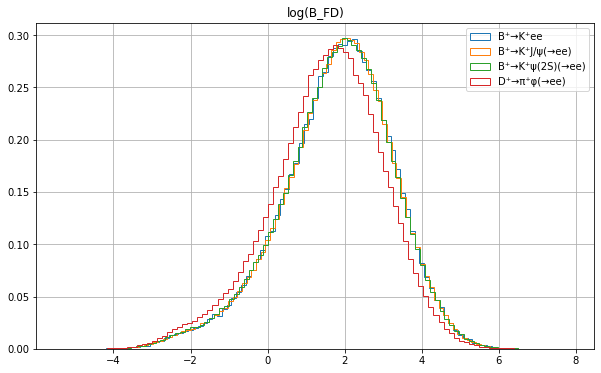

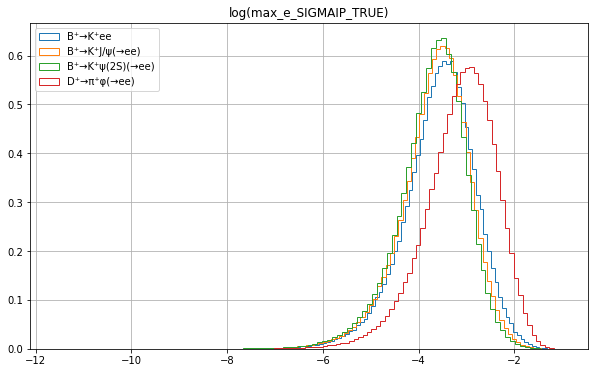

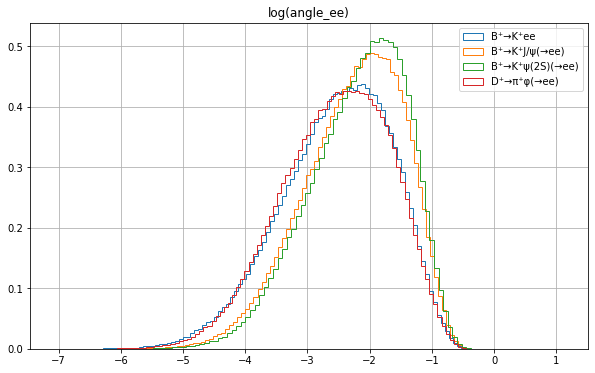

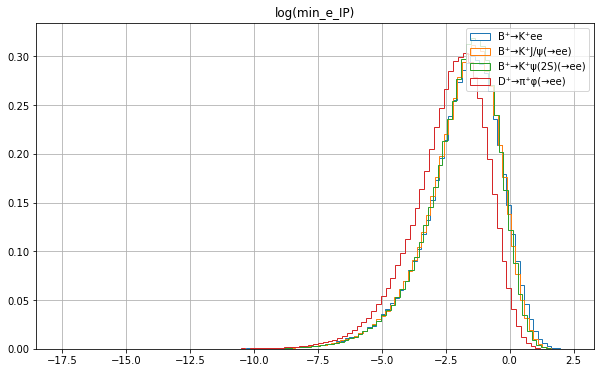

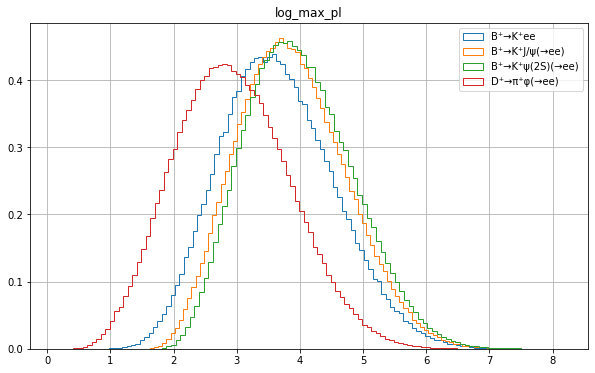

In [46]:
features_plots(train_ds_notrue)

### Preprocessing

In [47]:
class Loader(object):
    def __init__(self, dataset, batch_size=1, shuffle=True, drop_last=False, device=None):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.drop_last = drop_last
        self.device = device
    def __len__(self):
        data_len = len(self.dataset)
        if self.drop_last:
            off = 0
        else:
            off = self.batch_size - 1
        return (data_len + off) // self.batch_size
    def __iter__(self):
        data_len = len(self.dataset)
        indices = torch.randperm(data_len, device=self.device) if self.shuffle else None
        for i in range(0, data_len, self.batch_size):
            i_last = i + self.batch_size
            if (i_last > data_len):
                if self.drop_last:
                    break
                else:
                    i_last = data_len
            slc = slice(i, i_last)
            if indices is not None:
                yield self.dataset[indices[slc]]
            else:
                yield self.dataset[slc]

In [48]:
class Dataset(object):
    def __init__(self, features, sources, aliases={}, name=None):
        self.sources = sources
        self.features = features
        self.name = name
        self.counts = np.asarray([len(source) for source in self.sources])
        self.size = np.sum(self.counts)
        self.weights = self.size/self.counts/self.counts.size
        self.aliases = aliases
    def __len__(self):
        return np.sum(self.counts)
    def __repr__(self):
        return "DS%s" % self.name
    def X(self, **kwargs):
        ccounts = np.cumsum(self.counts)
        lower = ccounts - self.counts
        result = torch.empty(ccounts[-1], len(self.features), **kwargs)
        for i in range(ccounts.size):
            np_data = self.sources[i].get(self.features, aliases=self.aliases)
            result[lower[i]:ccounts[i]] = torch.as_tensor(np_data, **kwargs)
        return result        
    def Y(self, **kwargs):
        ccounts = np.cumsum(self.counts)
        result = torch.zeros(ccounts[-1], **kwargs)
        for i in range(1, ccounts.size):
            result[ccounts[i-1]:ccounts[i]] = i
        return result
    def Y_hot(self):
        ccounts = np.cumsum(self.counts)
        result = torch.zeros(ccounts[-1], ccounts.size, **kwargs)
        for i in range(1, ccounts.size):
            result[ccounts[i-1]:ccounts[i], i] = 0
        return result

In [49]:
feature_sets = [
    ("α,p", ["angle_ee", "log_max_pl"]),
    ("4", ["log(B_FD)", "log(angle_ee)", "log(min_e_IP)", "log(max_e_PT)"]),
    ("5", ["log(B_FD)", "log(angle_ee)", "log(min_e_IP)", "log(max_e_PT)", "log(max_e_SIGMAIP_TRUE)"]),
]
train_datasets = [
    ("₄", train_ds_notrue),
    ("₃", train_ds_notrue[:3]),
]

all_datasets = list()
for f in feature_sets:
    for t in train_datasets:
        all_datasets.append(Dataset(f[1], t[1], aliases, "%s[%s]"%(t[0],f[0])))
all_datasets

[DS₄[α,p], DS₃[α,p], DS₄[4], DS₃[4], DS₄[5], DS₃[5]]

In [50]:
class Scaler(torch.nn.Module):
    def __init__(self, dataset):
        super().__init__()
        self.features = dataset.features
        self.scaler = sklearn.preprocessing.StandardScaler()
        self.minmax = sklearn.preprocessing.MinMaxScaler()
        x = to_numpy(dataset.X())
        self.scaler.fit(x)
        self.minmax.fit(x)
        self.mu = torch.as_tensor(self.scaler.mean_, dtype=float, device=device)
        self.sigma = torch.as_tensor(self.scaler.scale_, dtype=float, device=device)
        self.min = self.minmax.data_min_
        self.max = self.minmax.data_max_
    def forward(self, data):
        return ((data-self.mu)/self.sigma).float()
    def transform(self, x):
        return self.scaler.transform(x)
    def inverse_transform(self, x):
        return self.scaler.inverse_transform(x)

In [51]:
def plot_ds(dataset, scaler=None, ax=None, scale=3.0):
    sc = Scaler(dataset) if scaler is None else scaler
    axis = plt.gca() if ax is None else ax
    for source in dataset.sources:
        x = source.get(dataset.features, dataset.aliases)[:10000,0:2]
        axis.scatter(*(x.T), marker=".", s=0.1, label="%s"%source.name())
    upper = np.repeat(scale, 2)[None,:]
    lower = -upper
    x_min, y_min = sc.min # sc.inverse_transform(lower)[0]
    x_max, y_max = sc.max # sc.inverse_transform(upper)[0]
    axis.set_xlabel(dataset.features[0])
    axis.set_ylabel(dataset.features[1])
    axis.set_xlim(x_min, x_max)
    axis.set_ylim(y_min, y_max)
    axis.set_aspect(1.0/axis.get_data_ratio(), adjustable='box')
    axis.set_title("DS%s"%dataset.name)
    
    def update_prop(handle, orig):
        handle.update_from(orig)
        handle.set_sizes([3.0])
        handle.set_linewidth(3.0)
        
    axis.legend(handler_map={
        mpl.collections.PathCollection:mpl.legend_handler.HandlerPathCollection(update_func=update_prop),
    })
    axis.grid()
    if ax is None:
        plt.show()

In [52]:
#fig, ax = plt.subplots(3, 2, figsize=(10, 15))
#for i in range(6):
#    plot_ds(all_datasets[i], scale=2.0, ax=ax[i//2,i%2])
#plt.show()

### NN

In [53]:
def model(inputs, outputs):
    return nn.Sequential(
        nn.Linear(inputs, 20), nn.Softplus(),
        nn.Linear(20, 20), nn.Softplus(),
        nn.Linear(20, 20), nn.Softplus(),
        nn.Linear(20, outputs),
    )

In [54]:
def train(model, loader, epochs=20, weight=None, accumulate=False):
    total_count = len(loader.dataset)
    model.train()
    model.zero_grad()
    opt = torch.optim.Adam(params=model.parameters())
    opt.zero_grad()
    wt = from_numpy(weight) if weight is not None else None
    for epoch in range(epochs):
        total_loss = 0
        for batch in loader:
            x, y = batch
            pred = model(x)
            loss = F.cross_entropy(
                input=pred,
                target=y,
                weight=wt,
                reduction='sum',
            )
            total_loss += loss
            count = x.shape[0] if not accumulate else total_count
            loss /= count
            loss.backward()
            if not accumulate:
                opt.step()
                opt.zero_grad()
        mean_loss = total_loss / total_count
        if accumulate:
            opt.step()
            opt.zero_grad()
        logging.info("Epoch %d, %f", epoch, mean_loss)
    model.eval()
    model.zero_grad(set_to_none=True)

### Weight limits estimation

In [55]:
def train_estimator(dataset, model, device=device):
    model.to(device)
    ds = torch.utils.data.TensorDataset(
        dataset.X(device=device, dtype=float),
        dataset.Y(device=device, dtype=torch.int64)
    )
    loader = Loader(ds, batch_size=100000, shuffle=True, device=device)
    train(model, loader, epochs=50, weight=dataset.weights, accumulate=False)
    loader = Loader(ds, batch_size=100000, shuffle=False, device=device)
    train(model, loader, epochs=50, weight=dataset.weights, accumulate=True)
    return model.eval()

In [56]:
def make_estimator(dataset, device=device):
    scaler = Scaler(dataset)
    m = model(len(dataset.features), len(dataset.sources))
    return torch.nn.Sequential(scaler, m).to(device)

In [57]:
%%time
all_est = list()
for ds in all_datasets:
    est = make_estimator(ds)
    train_estimator(ds, est)
    all_est.append(est)
all_est

INFO:root:Epoch 0, 1.429052
INFO:root:Epoch 1, 1.380216
INFO:root:Epoch 2, 1.365382
INFO:root:Epoch 3, 1.336100
INFO:root:Epoch 4, 1.275611
INFO:root:Epoch 5, 1.177279
INFO:root:Epoch 6, 1.083581
INFO:root:Epoch 7, 1.035325
INFO:root:Epoch 8, 1.009110
INFO:root:Epoch 9, 0.985025
INFO:root:Epoch 10, 0.960212
INFO:root:Epoch 11, 0.937413
INFO:root:Epoch 12, 0.920660
INFO:root:Epoch 13, 0.910883
INFO:root:Epoch 14, 0.905091
INFO:root:Epoch 15, 0.900707
INFO:root:Epoch 16, 0.896759
INFO:root:Epoch 17, 0.892905
INFO:root:Epoch 18, 0.888874
INFO:root:Epoch 19, 0.884540
INFO:root:Epoch 20, 0.879971
INFO:root:Epoch 21, 0.875465
INFO:root:Epoch 22, 0.871214
INFO:root:Epoch 23, 0.867320
INFO:root:Epoch 24, 0.863973
INFO:root:Epoch 25, 0.861101
INFO:root:Epoch 26, 0.858862
INFO:root:Epoch 27, 0.857018
INFO:root:Epoch 28, 0.855468
INFO:root:Epoch 29, 0.854057
INFO:root:Epoch 30, 0.852880
INFO:root:Epoch 31, 0.851683
INFO:root:Epoch 32, 0.850564
INFO:root:Epoch 33, 0.849513
INFO:root:Epoch 34, 0.84

INFO:root:Epoch 35, 0.983311
INFO:root:Epoch 36, 0.983281
INFO:root:Epoch 37, 0.983248
INFO:root:Epoch 38, 0.983236
INFO:root:Epoch 39, 0.983244
INFO:root:Epoch 40, 0.983249
INFO:root:Epoch 41, 0.983233
INFO:root:Epoch 42, 0.983203
INFO:root:Epoch 43, 0.983184
INFO:root:Epoch 44, 0.983181
INFO:root:Epoch 45, 0.983182
INFO:root:Epoch 46, 0.983172
INFO:root:Epoch 47, 0.983154
INFO:root:Epoch 48, 0.983137
INFO:root:Epoch 49, 0.983126
INFO:root:Epoch 0, 1.108641
INFO:root:Epoch 1, 1.096713
INFO:root:Epoch 2, 1.090441
INFO:root:Epoch 3, 1.082483
INFO:root:Epoch 4, 1.069394
INFO:root:Epoch 5, 1.050446
INFO:root:Epoch 6, 1.031900
INFO:root:Epoch 7, 1.021400
INFO:root:Epoch 8, 1.014842
INFO:root:Epoch 9, 1.009994
INFO:root:Epoch 10, 1.006330
INFO:root:Epoch 11, 1.003259
INFO:root:Epoch 12, 1.000388
INFO:root:Epoch 13, 0.997572
INFO:root:Epoch 14, 0.994921
INFO:root:Epoch 15, 0.992653
INFO:root:Epoch 16, 0.990799
INFO:root:Epoch 17, 0.989358
INFO:root:Epoch 18, 0.988264
INFO:root:Epoch 19, 0.98

INFO:root:Epoch 20, 0.970424
INFO:root:Epoch 21, 0.970272
INFO:root:Epoch 22, 0.970154
INFO:root:Epoch 23, 0.970174
INFO:root:Epoch 24, 0.970265
INFO:root:Epoch 25, 0.970291
INFO:root:Epoch 26, 0.970213
INFO:root:Epoch 27, 0.970123
INFO:root:Epoch 28, 0.970109
INFO:root:Epoch 29, 0.970157
INFO:root:Epoch 30, 0.970184
INFO:root:Epoch 31, 0.970144
INFO:root:Epoch 32, 0.970082
INFO:root:Epoch 33, 0.970061
INFO:root:Epoch 34, 0.970084
INFO:root:Epoch 35, 0.970101
INFO:root:Epoch 36, 0.970076
INFO:root:Epoch 37, 0.970033
INFO:root:Epoch 38, 0.970016
INFO:root:Epoch 39, 0.970028
INFO:root:Epoch 40, 0.970033
INFO:root:Epoch 41, 0.970012
INFO:root:Epoch 42, 0.969983
INFO:root:Epoch 43, 0.969971
INFO:root:Epoch 44, 0.969976
INFO:root:Epoch 45, 0.969973
INFO:root:Epoch 46, 0.969954
INFO:root:Epoch 47, 0.969933
INFO:root:Epoch 48, 0.969925
INFO:root:Epoch 49, 0.969925


CPU times: user 2min 55s, sys: 11.8 s, total: 3min 7s
Wall time: 3min 5s


[Sequential(
   (0): Scaler()
   (1): Sequential(
     (0): Linear(in_features=2, out_features=20, bias=True)
     (1): Softplus(beta=1, threshold=20)
     (2): Linear(in_features=20, out_features=20, bias=True)
     (3): Softplus(beta=1, threshold=20)
     (4): Linear(in_features=20, out_features=20, bias=True)
     (5): Softplus(beta=1, threshold=20)
     (6): Linear(in_features=20, out_features=4, bias=True)
   )
 ),
 Sequential(
   (0): Scaler()
   (1): Sequential(
     (0): Linear(in_features=2, out_features=20, bias=True)
     (1): Softplus(beta=1, threshold=20)
     (2): Linear(in_features=20, out_features=20, bias=True)
     (3): Softplus(beta=1, threshold=20)
     (4): Linear(in_features=20, out_features=20, bias=True)
     (5): Softplus(beta=1, threshold=20)
     (6): Linear(in_features=20, out_features=3, bias=True)
   )
 ),
 Sequential(
   (0): Scaler()
   (1): Sequential(
     (0): Linear(in_features=4, out_features=20, bias=True)
     (1): Softplus(beta=1, threshold=20)
 

In [58]:
def plot_field(f, sc, scale=3.0, name=None, vmin=0.0, vmax=1.0, ax=None, color_bar=True):
    axis = plt.gca() if ax is None else ax
    
    x_min, y_min = sc.min
    x_max, y_max = sc.max
    
    x1, y1 = sc.transform([[x_min, y_min]])[0]
    x2, y2 = sc.transform([[x_max, y_max]])[0]
    
    X_test = sc.inverse_transform(
        np.asarray(bridson.poisson_disc_samples(x2-x1, y2-y1, 0.02)) +
        np.asarray([x1, y1])
    )
    
    y_pred = f(X_test).ravel()
    xi = np.linspace(x_min, x_max, 301)
    yi = np.linspace(y_min, y_max, 301)
    zi = scipy.interpolate.griddata(X_test, y_pred, tuple(np.meshgrid(xi, yi)), method='linear')
    CS = axis.contourf(xi, yi, zi, 20, cmap=plt.cm.seismic,
                      vmax=vmax, vmin=vmin)
    if color_bar:
        plt.colorbar(ax=axis, mappable=CS)
    axis.set_xlim(x_min, x_max)
    axis.set_ylim(y_min, y_max)
    axis.set_xlabel(sc.features[0])
    axis.set_ylabel(sc.features[1])
    axis.grid()
    axis.set_aspect(1.0/axis.get_data_ratio(), adjustable='box')
    if name is not None:
        axis.set_title(name)
    if ax is None:
        plt.show()

In [59]:
def plot_one(f, sc, name=None, save=None, vmin=0.0, vmax=1.0, ax=None):
    axis = plt.gca() if ax is None else ax
    x_min, x_max = sc.min, sc.max
    X_test = np.linspace(x_min, x_max, 1001)
    y_pred = f(X_test).ravel()
    axis.plot(X_test, y_pred)
    axis.set_xlim(x_min, x_max)
    axis.set_ylim(vmin, vmax)
    axis.set_xlabel(sc.features[0])
    axis.grid()    
    if name is not None:
        axis.set_title(name)
    if ax is None:
        plt.show()

In [60]:
def plot_clf(clf, scaler, c0, c1, ax=None, scale=3.0, color_bar=True):
    fn = lambda x : x[:,c1] - x[:,c0]
    f_ = lambda x : torch.sigmoid(fn(clf(x)))
    f = ds.as_numpy(f_)
    name=r'$\sigma\left(\log\frac{p(x|%s)}{p(x|%s)}\right)$'%(df_index[ds.mapping[c1]],df_index[ds.mapping[c0]])
    plot_field(f, scaler, scale=scale, ax=ax, name=name, color_bar=color_bar)

In [61]:
def plot_clf_min_max(clf, ax_min=None, ax_max=None, scale=3.0):
    fn = lambda x : x[...,1:] - x[...,0:1]
    f_min = lambda x : torch.relu(torch.min(fn(clf(x)), dim=-1)[0])
    f_max = lambda x : torch.relu(torch.min(-fn(clf(x)), dim=-1)[0])
    name_min = r'$\min_i\left(\log\frac{p(x|c_i)}{p(x|c)}\right)_+$'
    name_max = r'$\min_i\left(\log\frac{p(x|c)}{p(x|c_i)}\right)_+$'
    plot_field(as_numpy(f_min), clf[0], scale=scale, name=name_min, vmax=None, ax=ax_min, color_bar=False)
    plot_field(as_numpy(f_max), clf[0], scale=scale, name=name_max, vmax=None, ax=ax_max, color_bar=False)

In [62]:
if False:
    fig, ax = plt.subplots(6, 3, figsize=(15, 30))
    for i in range(6):
        est = all_est[i]
        ds = all_datasets[i]
        plot_ds(ds, scaler=est[0], ax=ax[i,0])
        plot_clf_min_max(est, ax_min=ax[i,1], ax_max=ax[i,2])
    plt.show()

### Weighting function

In [63]:
def compute_lipschitz(model, loader, device=device):
    model.eval().to(device)
    sc = model[0]
    fn = model[1:]
    L = 0
    for batch in loader:
        x, y = batch
        x.to(device)
        model.zero_grad()
        x_ = sc(x)
        x_.requires_grad = True
        fx = fn(x_)
        loss = torch.sum(fx)
        loss.backward()
        L = max(L, torch.max(x_.grad.norm(dim=1)).item())
    return L

In [64]:
def ratio_estimator(vec):
    m_minus = np.max(-vec)
    m_plus = np.max(vec)
    m_sum = m_minus + m_plus
    return 1/m_minus

In [65]:
def create_w(model, loader, n_outs, n_classes):
    totals = torch.zeros(n_classes, dtype=torch.long, device=device)
    wsum = torch.zeros(n_outs, n_classes, dtype=torch.float, device=device)
    for batch in loader:
        x, y = batch
        y_one_hot = torch.nn.functional.one_hot(y, num_classes=n_classes) # B*n
        pred = model(x) # B*N
        totals += torch.sum(y_one_hot, dim=0) # n
        wsum += torch.sum(pred.view(-1,n_outs,1)*y_one_hot.view(-1,1,n_classes), dim=0) # N*n
    W = wsum/totals.view(1,-1)
    return W, totals.view(1,-1)

In [66]:
def make_weighting_lp(Wpinv):
    import scipy.optimize
    n_classes, n_outs = Wpinv.shape
    c = np.asarray([-1]+[0]*(n_classes-1))
    bounds = [(0,1),(0.02,0.02), (0.01,0.03), (0,0.07)][:n_classes]
    A_ub = np.vstack([Wpinv.T, -Wpinv.T])
    b_ub = np.hstack([np.ones(n_outs), np.zeros(n_outs)])
    res = scipy.optimize.linprog(c=c, bounds=bounds, A_ub=A_ub, b_ub=b_ub)
    return np.maximum(Wpinv.T@res.x,0) if res.success else None

In [67]:
@torch.no_grad()
def make_weighting(Wpinv, linear, selected_class, n_outs, n_classes):
    assert Wpinv.shape == (n_classes, n_outs)
    weights = make_weighting_lp(Wpinv)
    if weights is None:
        w0 = Wpinv[selected_class]
        m_minus = np.max(-w0)
        m_plus = np.max(w0)
        m_sum = m_minus + m_plus
        k = np.maximum(m_minus*50, m_plus*50/49)
        weights = (w0 + k/50)/k
        #weights = (w0 + m_minus)/m_sum
    linear.weight.data = from_numpy(weights).view(linear.weight.data.shape)

In [68]:
def train_pinv(model, loader, n_outs, n_classes, selected_class, epochs=50, alpha=0.001, dxl=0.001, target_L=None):
    clone = clone_model(model)
    scaler = model[0]
    meat = model[1:3] # with softmax
    base = model[:3]
    linear = model[3]
    opt = torch.optim.SGD(params=meat.parameters(), lr=1e-4)    
    dx_ = torch.tensor([[[-1]],[[1]]], dtype=torch.float, device=device) * dxl
    try:
        for epoch in range(epochs):
            model.eval()
            with torch.no_grad():
                W, counts = create_w(base, loader, n_outs, n_classes)
            W_np = to_numpy(W)
            W_pinv = np.linalg.pinv(W_np)
            det = np.linalg.det(W_np.T@W_np)
            W_pinv_ = from_numpy(W_pinv)
            W_pinv_T = W_pinv_.T

            # fill linear coeffs
            make_weighting(W_pinv, linear, selected_class, n_outs, n_classes)

            wcj = W_pinv[selected_class]                   # N
            wcj_ = (wcj<0)*0.98 - (wcj>1)*0.02
            #ix_min = np.argmin(wcj)
            #ix_max = np.argmax(wcj)
            #wcj_ = np.zeros(n_outs)
            #if m_minus * 49 > m_plus:
            #    wcj_[ix_min] = 1
            #else:
            #    wcj_[ix_max] = -1
            #wcj_[ix_min] = 0.98
            #wcj_[ix_max] = -0.02
            #wcj_ = np.log(1-np.minimum(wcj,0))-np.log(1+np.maximum(wcj-1,0))
            wki = np.sum(W_pinv*wcj_[None,:], axis=1)      # n
            W_m = np.multiply.outer(wcj, wki)              # N*n ~ W
            W_m_ = W_m/np.maximum(1,np.max(np.abs(W_m)))
            W_m_t = from_numpy(W_m_)

            for clone_par, model_par in zip(clone.parameters(), model.parameters()): 
                clone_par.data.copy_(model_par.data)
            #clone.load_state_dict(model.state_dict())

            model.train()
            opt.zero_grad()
            total_loss = 0    
            L = 0
            for batch in loader:
                x, y = batch

                y_one_hot = torch.nn.functional.one_hot(y, num_classes=n_classes) # B*n
                pred = base(x)

                wsum = torch.sum(pred.view(-1,n_outs,1)*y_one_hot.view(-1,1,n_classes), dim=0) # N*n
                W = wsum/counts

                loss_c = torch.sum(W*W_m_t)
                loss_d = -torch.sum(W*W_pinv_T)
                loss = loss_d + alpha * loss_c
                total_loss += loss
                loss.backward()

                # Lipschitz part of the loss

                if True:
                    clone.zero_grad()
                    x_ = clone[0](x)
                    x_.requires_grad = True
                    fx = clone[1:](x_)
                    L_loss = torch.sum(fx)
                    L_loss.backward()
                    dx = x_.grad
                    L = max(L, torch.max(dx.norm(dim=1)).item())

                    if target_L is not None:
                        ext_dx = dx[None,...] * dx_ # 2*B*n_features
                        ext_x = x_[None,...] + ext_dx

                        pred_dfx = meat(ext_x) # 2*B*N
                        dfx = (pred_dfx[1] - pred_dfx[0])/(2*dxl)/target_L
                        loss_L = torch.sum(F.relu(torch.abs(dfx)-1)**2) / len(loader.dataset)

                        total_loss += loss_L
                        loss_L.backward()

            opt.step()
            #logging.info("Epoch %d, loss=%f est=%f", epoch, total_loss, ratio_estimator(W_pinv[selected_class]))
            print("Epoch %d loss=%f W+c=%s det=%f L=%f" % (epoch, total_loss, W_pinv[selected_class], det, L))
    except KeyboardInterrupt:
        pass
    model.eval()
    model.zero_grad(set_to_none=True)
    
    with torch.no_grad():
        W, counts = create_w(base, loader, n_outs, n_classes)
        W_np = to_numpy(W)
        W_pinv = np.linalg.pinv(W_np)
        make_weighting(W_pinv, linear, selected_class, n_outs, n_classes)
    L = compute_lipschitz(model, loader)
    print("W=", W_np)
    print("W+=", W_pinv)
    print("L=", L)
    print("coef=", linear.weight.data.detach().cpu().numpy())

    return model

In [69]:
def train_weighting(model, dataset, n_outs, n_classes, selected_class, device=device, **kwargs):
    model.to(device)
    data = torch.utils.data.TensorDataset(
        dataset.X(device=device, dtype=torch.float),
        dataset.Y(device=device, dtype=torch.int64)
    )
    loader = Loader(data, batch_size=100000, shuffle=False, device=device)
    train_pinv(model, loader, n_outs, n_classes, selected_class, epochs=200, alpha=0.001)
    train_pinv(model, loader, n_outs, n_classes, selected_class, epochs=500, alpha=300, **kwargs)
    return model.eval()

In [70]:
class Weighting(torch.nn.Module):
    def __init__(self, scaler, model, n_outs=None, name=None, device=device):
        super().__init__()
        
        scaler_ = clone_model(scaler)
        model_ = clone_model(model)
        
        n_inputs = len(scaler_.features)
        if n_outs is None:
            with torch.no_grad():
                z = torch.zeros(1, n_inputs, dtype=torch.float, device=device)
                n_outs = model_.to(device)(z).shape[1]
        
        self.features = scaler_.features
        self.n_inputs = n_inputs
        self.n_outs = n_outs
        self.name = name
        
        self.model = torch.nn.Sequential(
            scaler_,
            model_,
            torch.nn.Softmax(dim=-1),
            torch.nn.Linear(n_outs, 1, bias=False),
        ).to(device).eval()

    def forward(self, x):
        return self.model(x)
        
    def train(self, dataset, n_classes=None, selected_class=0, **kwargs):
        if n_classes is None:
            n_classes = len(dataset.sources)
        return train_weighting(self.model, dataset, self.n_outs, n_classes, selected_class, **kwargs)

In [71]:
def w_from_est(estimator, name=None):
    return Weighting(estimator[0], estimator[1:], name=name)

In [72]:
%%time
results = dict()
for target_L in [None]:
    for est, ds in zip(all_est, all_datasets):
        name = "w%s@%s"%(ds.name, target_L)
        w = w_from_est(est, name=name)
        w.train(ds, target_L=target_L)
        results[target_L, ds.name] = w

Epoch 0 loss=-4.000059 W+c=[ 5.9072 -7.04    3.8616 -1.6188] det=0.000023 L=0.500711
Epoch 1 loss=-4.000059 W+c=[ 5.8996 -7.0138  3.8056 -1.6216] det=0.000023 L=0.502023
Epoch 2 loss=-4.000058 W+c=[ 5.892  -6.9879  3.751  -1.6245] det=0.000023 L=0.503462
Epoch 3 loss=-4.000058 W+c=[ 5.8845 -6.9624  3.6978 -1.6273] det=0.000024 L=0.504902
Epoch 4 loss=-4.000059 W+c=[ 5.8772 -6.9373  3.6459 -1.6301] det=0.000024 L=0.506342
Epoch 5 loss=-4.000059 W+c=[ 5.8699 -6.9125  3.5953 -1.6328] det=0.000025 L=0.507781
Epoch 6 loss=-4.000060 W+c=[ 5.8627 -6.8879  3.546  -1.6356] det=0.000025 L=0.509220
Epoch 7 loss=-4.000060 W+c=[ 5.8556 -6.8637  3.4978 -1.6383] det=0.000025 L=0.510656
Epoch 8 loss=-4.000062 W+c=[ 5.8486 -6.8399  3.4509 -1.641 ] det=0.000026 L=0.512093
Epoch 9 loss=-4.000060 W+c=[ 5.8417 -6.8163  3.405  -1.6437] det=0.000026 L=0.513527
Epoch 10 loss=-4.000062 W+c=[ 5.8349 -6.793   3.3603 -1.6464] det=0.000026 L=0.514961
Epoch 11 loss=-4.000062 W+c=[ 5.8282 -6.7699  3.3166 -1.649 ] de

Epoch 96 loss=-4.000072 W+c=[ 5.4605 -5.4209  1.5729 -1.8   ] det=0.000053 L=0.636845
Epoch 97 loss=-4.000072 W+c=[ 5.4577 -5.4093  1.5638 -1.8011] det=0.000053 L=0.638196
Epoch 98 loss=-4.000073 W+c=[ 5.4549 -5.3978  1.5547 -1.8021] det=0.000054 L=0.639559
Epoch 99 loss=-4.000074 W+c=[ 5.4522 -5.3863  1.5458 -1.8031] det=0.000054 L=0.640917
Epoch 100 loss=-4.000074 W+c=[ 5.4495 -5.3749  1.537  -1.8042] det=0.000054 L=0.642271
Epoch 101 loss=-4.000072 W+c=[ 5.4468 -5.3635  1.5283 -1.8052] det=0.000054 L=0.643619
Epoch 102 loss=-4.000073 W+c=[ 5.4441 -5.3522  1.5198 -1.8062] det=0.000055 L=0.644963
Epoch 103 loss=-4.000072 W+c=[ 5.4415 -5.3409  1.5113 -1.8071] det=0.000055 L=0.646303
Epoch 104 loss=-4.000073 W+c=[ 5.4389 -5.3297  1.503  -1.8081] det=0.000055 L=0.647639
Epoch 105 loss=-4.000073 W+c=[ 5.4363 -5.3186  1.4948 -1.8091] det=0.000056 L=0.648970
Epoch 106 loss=-4.000073 W+c=[ 5.4337 -5.3075  1.4866 -1.81  ] det=0.000056 L=0.650297
Epoch 107 loss=-4.000074 W+c=[ 5.4311 -5.2965  

Epoch 191 loss=-4.000074 W+c=[ 5.2631 -4.5199  1.0486 -1.8572] det=0.000078 L=0.749673
Epoch 192 loss=-4.000074 W+c=[ 5.2615 -4.512   1.0454 -1.8574] det=0.000078 L=0.750712
Epoch 193 loss=-4.000074 W+c=[ 5.2599 -4.5042  1.0422 -1.8577] det=0.000078 L=0.751749
Epoch 194 loss=-4.000074 W+c=[ 5.2583 -4.4964  1.0389 -1.858 ] det=0.000079 L=0.752784
Epoch 195 loss=-4.000073 W+c=[ 5.2567 -4.4886  1.0358 -1.8582] det=0.000079 L=0.753815
Epoch 196 loss=-4.000074 W+c=[ 5.2551 -4.4809  1.0326 -1.8585] det=0.000079 L=0.754844
Epoch 197 loss=-4.000075 W+c=[ 5.2535 -4.4732  1.0295 -1.8588] det=0.000080 L=0.755872
Epoch 198 loss=-4.000073 W+c=[ 5.2519 -4.4655  1.0264 -1.859 ] det=0.000080 L=0.756896
Epoch 199 loss=-4.000073 W+c=[ 5.2503 -4.4578  1.0234 -1.8593] det=0.000080 L=0.757918
W= [[0.3851 0.1558 0.0821 0.2685]
 [0.202  0.3003 0.2488 0.0291]
 [0.2243 0.5313 0.667  0.0091]
 [0.1886 0.0126 0.0022 0.6932]]
W+= [[  5.2488  -4.4502   1.0203  -1.8595]
 [ -5.7494  14.7069  -4.7841   1.6721]
 [  2.8

Epoch 82 loss=-13.194155 W+c=[10.0094 -0.7964  0.6484 -1.2738] det=0.000067 L=2.366649
Epoch 83 loss=-13.184732 W+c=[10.0142 -0.7913  0.6458 -1.2711] det=0.000067 L=2.376588
Epoch 84 loss=-13.175700 W+c=[10.0186 -0.7864  0.6433 -1.2685] det=0.000067 L=2.386467
Epoch 85 loss=-13.167043 W+c=[10.0227 -0.7815  0.6408 -1.266 ] det=0.000068 L=2.396302
Epoch 86 loss=-13.158751 W+c=[10.0264 -0.7768  0.6383 -1.2634] det=0.000068 L=2.406072
Epoch 87 loss=-13.150798 W+c=[10.0298 -0.7721  0.6359 -1.2609] det=0.000068 L=2.415798
Epoch 88 loss=-13.143177 W+c=[10.0328 -0.7675  0.6334 -1.2585] det=0.000068 L=2.425466
Epoch 89 loss=-13.135882 W+c=[10.0356 -0.7629  0.631  -1.256 ] det=0.000068 L=2.435088
Epoch 90 loss=-13.128898 W+c=[10.038  -0.7585  0.6286 -1.2536] det=0.000069 L=2.444670
Epoch 91 loss=-13.122203 W+c=[10.0401 -0.7541  0.6262 -1.2512] det=0.000069 L=2.454215
Epoch 92 loss=-13.115800 W+c=[10.0419 -0.7498  0.6238 -1.2489] det=0.000069 L=2.463715
Epoch 93 loss=-13.109671 W+c=[10.0435 -0.74

Epoch 176 loss=-13.013513 W+c=[ 9.7668 -0.5343  0.4728 -1.1105] det=0.000091 L=3.152876
Epoch 177 loss=-13.014139 W+c=[ 9.762  -0.5327  0.4715 -1.1093] det=0.000092 L=3.160233
Epoch 178 loss=-13.014783 W+c=[ 9.7571 -0.5312  0.4702 -1.1081] det=0.000092 L=3.167570
Epoch 179 loss=-13.015426 W+c=[ 9.7523 -0.5296  0.4688 -1.107 ] det=0.000092 L=3.174898
Epoch 180 loss=-13.016091 W+c=[ 9.7475 -0.5281  0.4675 -1.1058] det=0.000093 L=3.182217
Epoch 181 loss=-13.016752 W+c=[ 9.7426 -0.5266  0.4662 -1.1046] det=0.000093 L=3.189517
Epoch 182 loss=-13.017420 W+c=[ 9.7378 -0.5251  0.465  -1.1035] det=0.000093 L=3.196799
Epoch 183 loss=-13.018104 W+c=[ 9.733  -0.5236  0.4637 -1.1023] det=0.000093 L=3.204064
Epoch 184 loss=-13.018787 W+c=[ 9.7282 -0.5221  0.4624 -1.1012] det=0.000094 L=3.211310
Epoch 185 loss=-13.019476 W+c=[ 9.7234 -0.5206  0.4612 -1.1001] det=0.000094 L=3.218539
Epoch 186 loss=-13.020175 W+c=[ 9.7186 -0.5192  0.4599 -1.0989] det=0.000094 L=3.225753
Epoch 187 loss=-13.020883 W+c=[ 

Epoch 270 loss=-13.081648 W+c=[ 9.3473 -0.4283  0.3765 -1.0229] det=0.000117 L=3.784824
Epoch 271 loss=-13.082309 W+c=[ 9.3434 -0.4275  0.3757 -1.0222] det=0.000117 L=3.790994
Epoch 272 loss=-13.082978 W+c=[ 9.3394 -0.4267  0.3749 -1.0214] det=0.000118 L=3.797153
Epoch 273 loss=-13.083635 W+c=[ 9.3355 -0.4259  0.3741 -1.0207] det=0.000118 L=3.803299
Epoch 274 loss=-13.084291 W+c=[ 9.3315 -0.4251  0.3734 -1.02  ] det=0.000118 L=3.809436
Epoch 275 loss=-13.084950 W+c=[ 9.3276 -0.4243  0.3726 -1.0193] det=0.000118 L=3.815566
Epoch 276 loss=-13.085598 W+c=[ 9.3237 -0.4235  0.3718 -1.0185] det=0.000119 L=3.821680
Epoch 277 loss=-13.086252 W+c=[ 9.3198 -0.4227  0.371  -1.0178] det=0.000119 L=3.827787
Epoch 278 loss=-13.086905 W+c=[ 9.3159 -0.422   0.3703 -1.0171] det=0.000119 L=3.833877
Epoch 279 loss=-13.087543 W+c=[ 9.3121 -0.4212  0.3695 -1.0164] det=0.000119 L=3.839964
Epoch 280 loss=-13.088185 W+c=[ 9.3082 -0.4204  0.3688 -1.0157] det=0.000120 L=3.846039
Epoch 281 loss=-13.088827 W+c=[ 

Epoch 364 loss=-13.133735 W+c=[ 9.0185 -0.3684  0.3161 -0.9652] det=0.000140 L=4.324399
Epoch 365 loss=-13.134182 W+c=[ 9.0154 -0.3679  0.3156 -0.9646] det=0.000141 L=4.329747
Epoch 366 loss=-13.134637 W+c=[ 9.0123 -0.3674  0.315  -0.9641] det=0.000141 L=4.335092
Epoch 367 loss=-13.135079 W+c=[ 9.0093 -0.3669  0.3145 -0.9636] det=0.000141 L=4.340425
Epoch 368 loss=-13.135527 W+c=[ 9.0062 -0.3664  0.314  -0.9631] det=0.000141 L=4.345753
Epoch 369 loss=-13.135972 W+c=[ 9.0032 -0.3659  0.3135 -0.9626] det=0.000142 L=4.351069
Epoch 370 loss=-13.136409 W+c=[ 9.0001 -0.3654  0.313  -0.9621] det=0.000142 L=4.356385
Epoch 371 loss=-13.136851 W+c=[ 8.9971 -0.3649  0.3125 -0.9616] det=0.000142 L=4.361688
Epoch 372 loss=-13.137289 W+c=[ 8.9941 -0.3644  0.312  -0.9611] det=0.000142 L=4.366983
Epoch 373 loss=-13.137725 W+c=[ 8.9911 -0.364   0.3115 -0.9606] det=0.000143 L=4.372273
Epoch 374 loss=-13.138159 W+c=[ 8.9881 -0.3635  0.311  -0.9601] det=0.000143 L=4.377556
Epoch 375 loss=-13.138591 W+c=[ 

Epoch 458 loss=-13.168804 W+c=[ 8.7597 -0.3292  0.2747 -0.9231] det=0.000162 L=4.797547
Epoch 459 loss=-13.169106 W+c=[ 8.7573 -0.3288  0.2743 -0.9227] det=0.000162 L=4.802286
Epoch 460 loss=-13.169409 W+c=[ 8.7548 -0.3285  0.2739 -0.9223] det=0.000162 L=4.807020
Epoch 461 loss=-13.169706 W+c=[ 8.7524 -0.3281  0.2736 -0.9219] det=0.000162 L=4.811745
Epoch 462 loss=-13.170015 W+c=[ 8.7499 -0.3278  0.2732 -0.9215] det=0.000162 L=4.816463
Epoch 463 loss=-13.170313 W+c=[ 8.7475 -0.3275  0.2728 -0.9211] det=0.000163 L=4.821180
Epoch 464 loss=-13.170608 W+c=[ 8.7451 -0.3271  0.2725 -0.9208] det=0.000163 L=4.825891
Epoch 465 loss=-13.170905 W+c=[ 8.7426 -0.3268  0.2721 -0.9204] det=0.000163 L=4.830594
Epoch 466 loss=-13.171206 W+c=[ 8.7402 -0.3264  0.2717 -0.92  ] det=0.000163 L=4.835291
Epoch 467 loss=-13.171495 W+c=[ 8.7378 -0.3261  0.2714 -0.9196] det=0.000164 L=4.839986
Epoch 468 loss=-13.171788 W+c=[ 8.7354 -0.3258  0.271  -0.9192] det=0.000164 L=4.844674
Epoch 469 loss=-13.172083 W+c=[ 

Epoch 54 loss=-3.000077 W+c=[ 2.3097 -2.5392  1.3677] det=0.000405 L=0.622414
Epoch 55 loss=-3.000077 W+c=[ 2.3099 -2.5341  1.3643] det=0.000406 L=0.623357
Epoch 56 loss=-3.000077 W+c=[ 2.3102 -2.5289  1.3609] det=0.000408 L=0.624299
Epoch 57 loss=-3.000076 W+c=[ 2.3105 -2.5238  1.3575] det=0.000409 L=0.625241
Epoch 58 loss=-3.000078 W+c=[ 2.3108 -2.5187  1.3542] det=0.000410 L=0.626182
Epoch 59 loss=-3.000078 W+c=[ 2.311  -2.5136  1.3508] det=0.000412 L=0.627123
Epoch 60 loss=-3.000078 W+c=[ 2.3113 -2.5085  1.3475] det=0.000413 L=0.628063
Epoch 61 loss=-3.000077 W+c=[ 2.3116 -2.5034  1.3441] det=0.000414 L=0.629003
Epoch 62 loss=-3.000078 W+c=[ 2.3119 -2.4984  1.3408] det=0.000416 L=0.629942
Epoch 63 loss=-3.000078 W+c=[ 2.3121 -2.4934  1.3375] det=0.000417 L=0.630881
Epoch 64 loss=-3.000079 W+c=[ 2.3124 -2.4884  1.3342] det=0.000418 L=0.631820
Epoch 65 loss=-3.000079 W+c=[ 2.3127 -2.4834  1.3309] det=0.000420 L=0.632757
Epoch 66 loss=-3.000077 W+c=[ 2.3129 -2.4784  1.3277] det=0.0004

Epoch 159 loss=-3.000079 W+c=[ 2.3355 -2.0875  1.0692] det=0.000551 L=0.726248
Epoch 160 loss=-3.000080 W+c=[ 2.3357 -2.0839  1.0668] det=0.000553 L=0.727271
Epoch 161 loss=-3.000078 W+c=[ 2.3359 -2.0804  1.0645] det=0.000554 L=0.728295
Epoch 162 loss=-3.000079 W+c=[ 2.3362 -2.0769  1.0621] det=0.000556 L=0.729317
Epoch 163 loss=-3.000079 W+c=[ 2.3364 -2.0734  1.0598] det=0.000557 L=0.730340
Epoch 164 loss=-3.000079 W+c=[ 2.3366 -2.0698  1.0575] det=0.000559 L=0.731362
Epoch 165 loss=-3.000080 W+c=[ 2.3368 -2.0663  1.0552] det=0.000560 L=0.732385
Epoch 166 loss=-3.000079 W+c=[ 2.337  -2.0629  1.0528] det=0.000562 L=0.733406
Epoch 167 loss=-3.000078 W+c=[ 2.3372 -2.0594  1.0505] det=0.000563 L=0.734428
Epoch 168 loss=-3.000079 W+c=[ 2.3375 -2.0559  1.0482] det=0.000565 L=0.735449
Epoch 169 loss=-3.000078 W+c=[ 2.3377 -2.0525  1.046 ] det=0.000566 L=0.736471
Epoch 170 loss=-3.000078 W+c=[ 2.3379 -2.049   1.0437] det=0.000568 L=0.737492
Epoch 171 loss=-3.000077 W+c=[ 2.3381 -2.0456  1.041

Epoch 61 loss=-6.487798 W+c=[ 4.0597 -0.1701  0.1391] det=0.000331 L=6.795585
Epoch 62 loss=-6.464618 W+c=[ 4.065  -0.1679  0.138 ] det=0.000330 L=6.800289
Epoch 63 loss=-6.442227 W+c=[ 4.0702 -0.1658  0.1369] det=0.000329 L=6.804849
Epoch 64 loss=-6.420587 W+c=[ 4.075  -0.1637  0.1359] det=0.000329 L=6.809283
Epoch 65 loss=-6.399672 W+c=[ 4.0796 -0.1617  0.1349] det=0.000328 L=6.813606
Epoch 66 loss=-6.379438 W+c=[ 4.084  -0.1598  0.1339] det=0.000328 L=6.817836
Epoch 67 loss=-6.359863 W+c=[ 4.0882 -0.1579  0.133 ] det=0.000327 L=6.821990
Epoch 68 loss=-6.340920 W+c=[ 4.0921 -0.156   0.132 ] det=0.000327 L=6.826074
Epoch 69 loss=-6.322570 W+c=[ 4.0958 -0.1542  0.1311] det=0.000326 L=6.830649
Epoch 70 loss=-6.304807 W+c=[ 4.0993 -0.1525  0.1303] det=0.000326 L=6.835520
Epoch 71 loss=-6.287594 W+c=[ 4.1026 -0.1508  0.1294] det=0.000326 L=6.840318
Epoch 72 loss=-6.270906 W+c=[ 4.1058 -0.1491  0.1286] det=0.000325 L=6.845050
Epoch 73 loss=-6.254724 W+c=[ 4.1087 -0.1475  0.1278] det=0.0003

Epoch 166 loss=-5.659372 W+c=[ 4.051  -0.0806  0.0888] det=0.000399 L=7.249663
Epoch 167 loss=-5.656758 W+c=[ 4.0494 -0.0803  0.0886] det=0.000400 L=7.253414
Epoch 168 loss=-5.654172 W+c=[ 4.0477 -0.0799  0.0883] det=0.000401 L=7.257148
Epoch 169 loss=-5.651620 W+c=[ 4.0461 -0.0796  0.088 ] det=0.000403 L=7.260867
Epoch 170 loss=-5.649092 W+c=[ 4.0445 -0.0793  0.0878] det=0.000404 L=7.264568
Epoch 171 loss=-5.646590 W+c=[ 4.0429 -0.079   0.0875] det=0.000405 L=7.268251
Epoch 172 loss=-5.644114 W+c=[ 4.0413 -0.0787  0.0872] det=0.000407 L=7.271918
Epoch 173 loss=-5.641665 W+c=[ 4.0397 -0.0784  0.087 ] det=0.000408 L=7.275568
Epoch 174 loss=-5.639238 W+c=[ 4.0381 -0.0781  0.0867] det=0.000410 L=7.279203
Epoch 175 loss=-5.636836 W+c=[ 4.0365 -0.0778  0.0864] det=0.000411 L=7.282822
Epoch 176 loss=-5.634458 W+c=[ 4.0349 -0.0775  0.0862] det=0.000412 L=7.286423
Epoch 177 loss=-5.632100 W+c=[ 4.0333 -0.0772  0.0859] det=0.000414 L=7.290009
Epoch 178 loss=-5.629767 W+c=[ 4.0317 -0.0769  0.085

Epoch 270 loss=-5.473902 W+c=[ 3.9084 -0.0589  0.0647] det=0.000571 L=7.595146
Epoch 271 loss=-5.472599 W+c=[ 3.9073 -0.0587  0.0645] det=0.000573 L=7.598006
Epoch 272 loss=-5.471301 W+c=[ 3.9062 -0.0586  0.0643] det=0.000575 L=7.600857
Epoch 273 loss=-5.470019 W+c=[ 3.9051 -0.0585  0.0641] det=0.000577 L=7.603705
Epoch 274 loss=-5.468733 W+c=[ 3.904  -0.0583  0.0639] det=0.000579 L=7.606771
Epoch 275 loss=-5.467453 W+c=[ 3.9029 -0.0582  0.0637] det=0.000581 L=7.609831
Epoch 276 loss=-5.466186 W+c=[ 3.9019 -0.0581  0.0635] det=0.000583 L=7.612881
Epoch 277 loss=-5.464917 W+c=[ 3.9008 -0.0579  0.0633] det=0.000584 L=7.615924
Epoch 278 loss=-5.463646 W+c=[ 3.8998 -0.0578  0.0631] det=0.000586 L=7.618959
Epoch 279 loss=-5.462396 W+c=[ 3.8987 -0.0577  0.0629] det=0.000588 L=7.621987
Epoch 280 loss=-5.461139 W+c=[ 3.8977 -0.0575  0.0627] det=0.000590 L=7.625005
Epoch 281 loss=-5.459894 W+c=[ 3.8966 -0.0574  0.0626] det=0.000592 L=7.628016
Epoch 282 loss=-5.458652 W+c=[ 3.8956 -0.0573  0.062

Epoch 374 loss=-5.360851 W+c=[ 3.8151 -0.0483  0.0474] det=0.000792 L=7.878928
Epoch 375 loss=-5.359926 W+c=[ 3.8143 -0.0483  0.0473] det=0.000794 L=7.881350
Epoch 376 loss=-5.359016 W+c=[ 3.8136 -0.0482  0.0472] det=0.000796 L=7.883767
Epoch 377 loss=-5.358098 W+c=[ 3.8128 -0.0481  0.047 ] det=0.000798 L=7.886181
Epoch 378 loss=-5.357183 W+c=[ 3.8121 -0.048   0.0469] det=0.000801 L=7.888587
Epoch 379 loss=-5.356277 W+c=[ 3.8114 -0.048   0.0468] det=0.000803 L=7.891119
Epoch 380 loss=-5.355366 W+c=[ 3.8106 -0.0479  0.0466] det=0.000805 L=7.893776
Epoch 381 loss=-5.354464 W+c=[ 3.8099 -0.0478  0.0465] det=0.000807 L=7.896427
Epoch 382 loss=-5.353561 W+c=[ 3.8092 -0.0477  0.0464] det=0.000810 L=7.899073
Epoch 383 loss=-5.352656 W+c=[ 3.8085 -0.0477  0.0462] det=0.000812 L=7.901716
Epoch 384 loss=-5.351759 W+c=[ 3.8077 -0.0476  0.0461] det=0.000814 L=7.904353
Epoch 385 loss=-5.350867 W+c=[ 3.807  -0.0475  0.046 ] det=0.000817 L=7.906985
Epoch 386 loss=-5.349974 W+c=[ 3.8063 -0.0475  0.045

Epoch 478 loss=-5.276729 W+c=[ 3.7481 -0.042   0.0358] det=0.001033 L=8.133117
Epoch 479 loss=-5.276020 W+c=[ 3.7475 -0.0419  0.0357] det=0.001035 L=8.135351
Epoch 480 loss=-5.275303 W+c=[ 3.747  -0.0419  0.0356] det=0.001037 L=8.137580
Epoch 481 loss=-5.274601 W+c=[ 3.7464 -0.0418  0.0356] det=0.001040 L=8.139806
Epoch 482 loss=-5.273894 W+c=[ 3.7458 -0.0418  0.0355] det=0.001042 L=8.142029
Epoch 483 loss=-5.273190 W+c=[ 3.7453 -0.0417  0.0354] det=0.001044 L=8.144243
Epoch 484 loss=-5.272491 W+c=[ 3.7447 -0.0417  0.0353] det=0.001047 L=8.146457
Epoch 485 loss=-5.271791 W+c=[ 3.7442 -0.0416  0.0352] det=0.001049 L=8.148665
Epoch 486 loss=-5.271095 W+c=[ 3.7436 -0.0416  0.0351] det=0.001051 L=8.150868
Epoch 487 loss=-5.270390 W+c=[ 3.7431 -0.0415  0.035 ] det=0.001054 L=8.153068
Epoch 488 loss=-5.269699 W+c=[ 3.7425 -0.0415  0.0349] det=0.001056 L=8.155260
Epoch 489 loss=-5.269001 W+c=[ 3.742  -0.0414  0.0349] det=0.001058 L=8.157452
Epoch 490 loss=-5.268311 W+c=[ 3.7414 -0.0414  0.034

Epoch 70 loss=-4.000021 W+c=[ 10.6826 -15.1528   6.2709  -1.6123] det=0.000001 L=0.179516
Epoch 71 loss=-4.000023 W+c=[ 10.6811 -15.1138   6.2378  -1.6146] det=0.000001 L=0.179655
Epoch 72 loss=-4.000021 W+c=[ 10.6795 -15.075    6.205   -1.617 ] det=0.000001 L=0.179792
Epoch 73 loss=-4.000020 W+c=[ 10.6779 -15.0363   6.1726  -1.6193] det=0.000001 L=0.179929
Epoch 74 loss=-4.000021 W+c=[ 10.6762 -14.9979   6.1407  -1.6216] det=0.000001 L=0.180065
Epoch 75 loss=-4.000024 W+c=[ 10.6746 -14.9598   6.1092  -1.624 ] det=0.000001 L=0.180199
Epoch 76 loss=-4.000019 W+c=[ 10.6729 -14.9217   6.078   -1.6263] det=0.000001 L=0.180333
Epoch 77 loss=-4.000020 W+c=[ 10.6712 -14.8839   6.0472  -1.6287] det=0.000001 L=0.180465
Epoch 78 loss=-4.000020 W+c=[ 10.6694 -14.8463   6.0168  -1.631 ] det=0.000001 L=0.180597
Epoch 79 loss=-4.000023 W+c=[ 10.6677 -14.8088   5.9868  -1.6333] det=0.000001 L=0.180727
Epoch 80 loss=-4.000020 W+c=[ 10.6659 -14.7716   5.9571  -1.6356] det=0.000001 L=0.180857
Epoch 81 l

Epoch 161 loss=-4.000027 W+c=[ 10.4748 -12.2864   4.3455  -1.8076] det=0.000002 L=0.202498
Epoch 162 loss=-4.000025 W+c=[ 10.4721 -12.2613   4.3321  -1.8095] det=0.000002 L=0.202708
Epoch 163 loss=-4.000025 W+c=[ 10.4695 -12.2363   4.3189  -1.8113] det=0.000002 L=0.202916
Epoch 164 loss=-4.000025 W+c=[ 10.4668 -12.2114   4.3057  -1.8132] det=0.000002 L=0.203123
Epoch 165 loss=-4.000023 W+c=[ 10.4642 -12.1867   4.2927  -1.8151] det=0.000002 L=0.203326
Epoch 166 loss=-4.000025 W+c=[ 10.4615 -12.162    4.2797  -1.817 ] det=0.000002 L=0.203528
Epoch 167 loss=-4.000027 W+c=[ 10.4588 -12.1375   4.2669  -1.8188] det=0.000002 L=0.203728
Epoch 168 loss=-4.000026 W+c=[ 10.4562 -12.1131   4.2541  -1.8207] det=0.000002 L=0.203926
Epoch 169 loss=-4.000025 W+c=[ 10.4535 -12.0888   4.2414  -1.8225] det=0.000002 L=0.204122
Epoch 170 loss=-4.000028 W+c=[ 10.4509 -12.0647   4.2289  -1.8244] det=0.000002 L=0.204316
Epoch 171 loss=-4.000026 W+c=[ 10.4482 -12.0406   4.2164  -1.8262] det=0.000002 L=0.204508

Epoch 50 loss=-9.468241 W+c=[17.2156 -4.3106  3.563  -1.859 ] det=0.000002 L=0.565367
Epoch 51 loss=-9.460986 W+c=[17.2454 -4.2861  3.5469 -1.8561] det=0.000002 L=0.569120
Epoch 52 loss=-9.454198 W+c=[17.2738 -4.2622  3.5309 -1.8531] det=0.000002 L=0.572828
Epoch 53 loss=-9.447822 W+c=[17.3007 -4.2389  3.5148 -1.8501] det=0.000002 L=0.576493
Epoch 54 loss=-9.441845 W+c=[17.3263 -4.216   3.4988 -1.847 ] det=0.000002 L=0.580119
Epoch 55 loss=-9.436257 W+c=[17.3507 -4.1937  3.4829 -1.8439] det=0.000002 L=0.583708
Epoch 56 loss=-9.431019 W+c=[17.3739 -4.1718  3.467  -1.8408] det=0.000002 L=0.587259
Epoch 57 loss=-9.426108 W+c=[17.396  -4.1504  3.4512 -1.8376] det=0.000002 L=0.590775
Epoch 58 loss=-9.421516 W+c=[17.417  -4.1294  3.4355 -1.8344] det=0.000002 L=0.594257
Epoch 59 loss=-9.417216 W+c=[17.437  -4.1088  3.4199 -1.8312] det=0.000002 L=0.597708
Epoch 60 loss=-9.413189 W+c=[17.4561 -4.0885  3.4043 -1.8279] det=0.000002 L=0.601128
Epoch 61 loss=-9.409431 W+c=[17.4742 -4.0687  3.3889 -

Epoch 145 loss=-9.354081 W+c=[17.883  -3.0495  2.4885 -1.5273] det=0.000002 L=0.824342
Epoch 146 loss=-9.353735 W+c=[17.8845 -3.0414  2.4814 -1.524 ] det=0.000002 L=0.826557
Epoch 147 loss=-9.353375 W+c=[17.8861 -3.0334  2.4744 -1.5206] det=0.000002 L=0.828764
Epoch 148 loss=-9.353007 W+c=[17.8876 -3.0254  2.4674 -1.5173] det=0.000002 L=0.830961
Epoch 149 loss=-9.352625 W+c=[17.8891 -3.0174  2.4605 -1.514 ] det=0.000003 L=0.833149
Epoch 150 loss=-9.352240 W+c=[17.8907 -3.0096  2.4536 -1.5108] det=0.000003 L=0.835326
Epoch 151 loss=-9.351842 W+c=[17.8922 -3.0017  2.4468 -1.5075] det=0.000003 L=0.837495
Epoch 152 loss=-9.351429 W+c=[17.8937 -2.994   2.44   -1.5042] det=0.000003 L=0.839654
Epoch 153 loss=-9.351009 W+c=[17.8953 -2.9862  2.4333 -1.501 ] det=0.000003 L=0.841806
Epoch 154 loss=-9.350578 W+c=[17.8968 -2.9786  2.4266 -1.4977] det=0.000003 L=0.843947
Epoch 155 loss=-9.350139 W+c=[17.8984 -2.9709  2.42   -1.4945] det=0.000003 L=0.846079
Epoch 156 loss=-9.349687 W+c=[17.8999 -2.96

Epoch 240 loss=-9.280846 W+c=[18.0509 -2.4644  1.9877 -1.2524] det=0.000003 L=1.065863
Epoch 241 loss=-9.279752 W+c=[18.053  -2.4597  1.9838 -1.2499] det=0.000003 L=1.068432
Epoch 242 loss=-9.278653 W+c=[18.055  -2.455   1.9798 -1.2474] det=0.000003 L=1.070993
Epoch 243 loss=-9.277547 W+c=[18.0571 -2.4504  1.9759 -1.245 ] det=0.000003 L=1.073545
Epoch 244 loss=-9.276438 W+c=[18.0592 -2.4458  1.972  -1.2425] det=0.000003 L=1.076090
Epoch 245 loss=-9.275330 W+c=[18.0613 -2.4412  1.9681 -1.24  ] det=0.000003 L=1.078624
Epoch 246 loss=-9.274209 W+c=[18.0633 -2.4366  1.9642 -1.2376] det=0.000003 L=1.081152
Epoch 247 loss=-9.273091 W+c=[18.0654 -2.4321  1.9603 -1.2351] det=0.000003 L=1.083672
Epoch 248 loss=-9.271964 W+c=[18.0675 -2.4276  1.9565 -1.2327] det=0.000003 L=1.086182
Epoch 249 loss=-9.270835 W+c=[18.0696 -2.423   1.9527 -1.2303] det=0.000003 L=1.088687
Epoch 250 loss=-9.269709 W+c=[18.0717 -2.4186  1.9489 -1.2278] det=0.000003 L=1.091180
Epoch 251 loss=-9.268571 W+c=[18.0738 -2.41

Epoch 335 loss=-9.165290 W+c=[18.2561 -2.1026  1.6776 -1.0454] det=0.000004 L=1.303064
Epoch 336 loss=-9.164021 W+c=[18.2583 -2.0995  1.6749 -1.0435] det=0.000004 L=1.305724
Epoch 337 loss=-9.162747 W+c=[18.2604 -2.0965  1.6722 -1.0416] det=0.000004 L=1.308382
Epoch 338 loss=-9.161478 W+c=[18.2626 -2.0934  1.6696 -1.0397] det=0.000004 L=1.311032
Epoch 339 loss=-9.160213 W+c=[18.2648 -2.0904  1.6669 -1.0378] det=0.000004 L=1.313682
Epoch 340 loss=-9.158941 W+c=[18.2669 -2.0873  1.6643 -1.0359] det=0.000004 L=1.316329
Epoch 341 loss=-9.157673 W+c=[18.269  -2.0843  1.6616 -1.034 ] det=0.000004 L=1.318970
Epoch 342 loss=-9.156405 W+c=[18.2712 -2.0813  1.659  -1.0322] det=0.000004 L=1.321607
Epoch 343 loss=-9.155138 W+c=[18.2733 -2.0782  1.6563 -1.0303] det=0.000004 L=1.324239
Epoch 344 loss=-9.153868 W+c=[18.2755 -2.0753  1.6537 -1.0284] det=0.000004 L=1.326870
Epoch 345 loss=-9.152603 W+c=[18.2776 -2.0723  1.6511 -1.0266] det=0.000004 L=1.329495
Epoch 346 loss=-9.151338 W+c=[18.2797 -2.06

Epoch 430 loss=-9.048110 W+c=[18.4454 -1.8538  1.4573 -0.8843] det=0.000005 L=1.544831
Epoch 431 loss=-9.046941 W+c=[18.4471 -1.8516  1.4553 -0.8828] det=0.000005 L=1.547629
Epoch 432 loss=-9.045773 W+c=[18.4489 -1.8494  1.4533 -0.8813] det=0.000005 L=1.550422
Epoch 433 loss=-9.044609 W+c=[18.4506 -1.8472  1.4513 -0.8798] det=0.000005 L=1.553211
Epoch 434 loss=-9.043445 W+c=[18.4524 -1.845   1.4494 -0.8783] det=0.000005 L=1.555995
Epoch 435 loss=-9.042274 W+c=[18.4541 -1.8428  1.4474 -0.8768] det=0.000005 L=1.558775
Epoch 436 loss=-9.041119 W+c=[18.4559 -1.8406  1.4454 -0.8753] det=0.000005 L=1.561550
Epoch 437 loss=-9.039954 W+c=[18.4576 -1.8384  1.4434 -0.8738] det=0.000005 L=1.564321
Epoch 438 loss=-9.038797 W+c=[18.4593 -1.8363  1.4415 -0.8723] det=0.000005 L=1.567087
Epoch 439 loss=-9.037642 W+c=[18.461  -1.8341  1.4395 -0.8708] det=0.000005 L=1.569848
Epoch 440 loss=-9.036486 W+c=[18.4628 -1.8319  1.4376 -0.8693] det=0.000005 L=1.572604
Epoch 441 loss=-9.035332 W+c=[18.4645 -1.82

Epoch 22 loss=-3.000020 W+c=[  6.2056 -12.5763   8.0509] det=0.000006 L=0.119078
Epoch 23 loss=-3.000018 W+c=[  6.2084 -12.5333   8.0295] det=0.000006 L=0.119232
Epoch 24 loss=-3.000018 W+c=[  6.2112 -12.4908   8.0082] det=0.000006 L=0.119384
Epoch 25 loss=-3.000021 W+c=[  6.214  -12.4486   7.9871] det=0.000006 L=0.119535
Epoch 26 loss=-3.000019 W+c=[  6.2168 -12.4067   7.9661] det=0.000006 L=0.119684
Epoch 27 loss=-3.000020 W+c=[  6.2196 -12.3651   7.9453] det=0.000006 L=0.119832
Epoch 28 loss=-3.000016 W+c=[  6.2224 -12.3239   7.9246] det=0.000006 L=0.119978
Epoch 29 loss=-3.000021 W+c=[  6.2252 -12.283    7.904 ] det=0.000006 L=0.120123
Epoch 30 loss=-3.000018 W+c=[  6.2279 -12.2424   7.8836] det=0.000006 L=0.120267
Epoch 31 loss=-3.000016 W+c=[  6.2307 -12.2021   7.8633] det=0.000006 L=0.120409
Epoch 32 loss=-3.000019 W+c=[  6.2334 -12.1622   7.8432] det=0.000006 L=0.120550
Epoch 33 loss=-3.000018 W+c=[  6.2361 -12.1226   7.8231] det=0.000006 L=0.120690
Epoch 34 loss=-3.000020 W+c=

Epoch 124 loss=-3.000025 W+c=[ 6.4398 -9.5203  6.442 ] det=0.000009 L=0.140745
Epoch 125 loss=-3.000026 W+c=[ 6.4416 -9.5     6.4306] det=0.000009 L=0.140928
Epoch 126 loss=-3.000023 W+c=[ 6.4433 -9.4797  6.4191] det=0.000009 L=0.141111
Epoch 127 loss=-3.000024 W+c=[ 6.445  -9.4597  6.4078] det=0.000009 L=0.141293
Epoch 128 loss=-3.000028 W+c=[ 6.4466 -9.4398  6.3965] det=0.000009 L=0.141474
Epoch 129 loss=-3.000025 W+c=[ 6.4483 -9.42    6.3853] det=0.000009 L=0.141653
Epoch 130 loss=-3.000025 W+c=[ 6.45   -9.4003  6.3741] det=0.000009 L=0.141832
Epoch 131 loss=-3.000024 W+c=[ 6.4516 -9.3807  6.363 ] det=0.000009 L=0.142010
Epoch 132 loss=-3.000024 W+c=[ 6.4533 -9.3613  6.352 ] det=0.000009 L=0.142188
Epoch 133 loss=-3.000026 W+c=[ 6.4549 -9.342   6.341 ] det=0.000009 L=0.142364
Epoch 134 loss=-3.000027 W+c=[ 6.4565 -9.3229  6.3301] det=0.000009 L=0.142540
Epoch 135 loss=-3.000027 W+c=[ 6.4581 -9.3038  6.3192] det=0.000009 L=0.142715
Epoch 136 loss=-3.000027 W+c=[ 6.4597 -9.2849  6.308

Epoch 26 loss=-8.265574 W+c=[10.3906 -3.4626  3.3961] det=0.000008 L=0.342270
Epoch 27 loss=-8.199689 W+c=[10.4909 -3.4166  3.3774] det=0.000008 L=0.348720
Epoch 28 loss=-8.137730 W+c=[10.5874 -3.3732  3.3602] det=0.000008 L=0.355155
Epoch 29 loss=-8.079393 W+c=[10.6803 -3.332   3.3442] det=0.000008 L=0.361234
Epoch 30 loss=-8.024442 W+c=[10.7697 -3.2929  3.3294] det=0.000008 L=0.367829
Epoch 31 loss=-7.972614 W+c=[10.8556 -3.2556  3.3157] det=0.000008 L=0.374724
Epoch 32 loss=-7.923705 W+c=[10.9381 -3.2202  3.303 ] det=0.000008 L=0.381289
Epoch 33 loss=-7.877511 W+c=[11.0174 -3.1864  3.2912] det=0.000007 L=0.387550
Epoch 34 loss=-7.833842 W+c=[11.0936 -3.154   3.2802] det=0.000007 L=0.393530
Epoch 35 loss=-7.792551 W+c=[11.1667 -3.123   3.27  ] det=0.000007 L=0.399253
Epoch 36 loss=-7.753451 W+c=[11.2368 -3.0933  3.2605] det=0.000007 L=0.404741
Epoch 37 loss=-7.716431 W+c=[11.3041 -3.0648  3.2517] det=0.000007 L=0.410014
Epoch 38 loss=-7.681331 W+c=[11.3685 -3.0374  3.2435] det=0.0000

Epoch 131 loss=-6.872859 W+c=[12.5291 -1.9354  3.0178] det=0.000006 L=0.719325
Epoch 132 loss=-6.869995 W+c=[12.527  -1.9286  3.0149] det=0.000006 L=0.722124
Epoch 133 loss=-6.867138 W+c=[12.5249 -1.9219  3.012 ] det=0.000006 L=0.724914
Epoch 134 loss=-6.864281 W+c=[12.5228 -1.9153  3.009 ] det=0.000006 L=0.727694
Epoch 135 loss=-6.861419 W+c=[12.5207 -1.9087  3.0059] det=0.000006 L=0.730464
Epoch 136 loss=-6.858555 W+c=[12.5186 -1.9022  3.0028] det=0.000006 L=0.733224
Epoch 137 loss=-6.855692 W+c=[12.5165 -1.8956  2.9997] det=0.000006 L=0.735973
Epoch 138 loss=-6.852825 W+c=[12.5144 -1.8892  2.9966] det=0.000006 L=0.738712
Epoch 139 loss=-6.849953 W+c=[12.5123 -1.8828  2.9934] det=0.000006 L=0.741440
Epoch 140 loss=-6.847086 W+c=[12.5102 -1.8764  2.9901] det=0.000006 L=0.744158
Epoch 141 loss=-6.844213 W+c=[12.5081 -1.87    2.9869] det=0.000006 L=0.746865
Epoch 142 loss=-6.841326 W+c=[12.5061 -1.8637  2.9836] det=0.000006 L=0.749562
Epoch 143 loss=-6.838438 W+c=[12.504  -1.8575  2.980

Epoch 235 loss=-6.547239 W+c=[12.4021 -1.4091  2.5618] det=0.000008 L=1.101070
Epoch 236 loss=-6.543903 W+c=[12.4019 -1.4053  2.5565] det=0.000008 L=1.105527
Epoch 237 loss=-6.540568 W+c=[12.4018 -1.4015  2.5512] det=0.000008 L=1.109984
Epoch 238 loss=-6.537230 W+c=[12.4017 -1.3978  2.5459] det=0.000008 L=1.114441
Epoch 239 loss=-6.533894 W+c=[12.4015 -1.394   2.5406] det=0.000008 L=1.118900
Epoch 240 loss=-6.530555 W+c=[12.4014 -1.3903  2.5353] det=0.000008 L=1.123360
Epoch 241 loss=-6.527224 W+c=[12.4014 -1.3866  2.53  ] det=0.000008 L=1.127822
Epoch 242 loss=-6.523881 W+c=[12.4013 -1.3829  2.5247] det=0.000008 L=1.132283
Epoch 243 loss=-6.520555 W+c=[12.4012 -1.3792  2.5193] det=0.000008 L=1.136744
Epoch 244 loss=-6.517212 W+c=[12.4012 -1.3756  2.514 ] det=0.000008 L=1.141206
Epoch 245 loss=-6.513876 W+c=[12.4012 -1.3719  2.5087] det=0.000008 L=1.145668
Epoch 246 loss=-6.510540 W+c=[12.4012 -1.3683  2.5033] det=0.000008 L=1.150132
Epoch 247 loss=-6.507205 W+c=[12.4011 -1.3647  2.498

Epoch 339 loss=-6.211399 W+c=[12.4404 -1.094   2.0135] det=0.000009 L=1.601763
Epoch 340 loss=-6.208378 W+c=[12.4411 -1.0916  2.0086] det=0.000009 L=1.608057
Epoch 341 loss=-6.205355 W+c=[12.4417 -1.0892  2.0036] det=0.000010 L=1.614360
Epoch 342 loss=-6.202333 W+c=[12.4424 -1.0868  1.9986] det=0.000010 L=1.620672
Epoch 343 loss=-6.199322 W+c=[12.4431 -1.0845  1.9936] det=0.000010 L=1.626991
Epoch 344 loss=-6.196314 W+c=[12.4438 -1.0821  1.9887] det=0.000010 L=1.633318
Epoch 345 loss=-6.193308 W+c=[12.4445 -1.0798  1.9837] det=0.000010 L=1.639652
Epoch 346 loss=-6.190319 W+c=[12.4452 -1.0774  1.9788] det=0.000010 L=1.645997
Epoch 347 loss=-6.187321 W+c=[12.4459 -1.0751  1.9739] det=0.000010 L=1.652346
Epoch 348 loss=-6.184333 W+c=[12.4466 -1.0728  1.969 ] det=0.000010 L=1.658705
Epoch 349 loss=-6.181355 W+c=[12.4473 -1.0705  1.9641] det=0.000010 L=1.665070
Epoch 350 loss=-6.178375 W+c=[12.448  -1.0682  1.9592] det=0.000010 L=1.671443
Epoch 351 loss=-6.175408 W+c=[12.4488 -1.0659  1.954

Epoch 443 loss=-5.925433 W+c=[12.5164 -0.8892  1.5509] det=0.000012 L=2.287351
Epoch 444 loss=-5.922977 W+c=[12.5171 -0.8876  1.547 ] det=0.000012 L=2.294124
Epoch 445 loss=-5.920522 W+c=[12.5178 -0.886   1.5432] det=0.000012 L=2.300898
Epoch 446 loss=-5.918077 W+c=[12.5185 -0.8844  1.5393] det=0.000012 L=2.307675
Epoch 447 loss=-5.915633 W+c=[12.5192 -0.8828  1.5355] det=0.000012 L=2.314446
Epoch 448 loss=-5.913196 W+c=[12.5199 -0.8813  1.5317] det=0.000012 L=2.321226
Epoch 449 loss=-5.910761 W+c=[12.5206 -0.8797  1.5279] det=0.000012 L=2.328003
Epoch 450 loss=-5.908340 W+c=[12.5213 -0.8781  1.5241] det=0.000012 L=2.334780
Epoch 451 loss=-5.905918 W+c=[12.522  -0.8765  1.5203] det=0.000012 L=2.341562
Epoch 452 loss=-5.903503 W+c=[12.5227 -0.875   1.5165] det=0.000012 L=2.348341
Epoch 453 loss=-5.901095 W+c=[12.5234 -0.8734  1.5128] det=0.000012 L=2.355120
Epoch 454 loss=-5.898692 W+c=[12.5241 -0.8719  1.509 ] det=0.000012 L=2.361902
Epoch 455 loss=-5.896293 W+c=[12.5247 -0.8703  1.505

Epoch 39 loss=-4.000017 W+c=[ 10.5645 -16.5636   8.6851  -1.5365] det=0.000001 L=0.158638
Epoch 40 loss=-4.000018 W+c=[ 10.5626 -16.521    8.6494  -1.5378] det=0.000001 L=0.158604
Epoch 41 loss=-4.000020 W+c=[ 10.5607 -16.4788   8.614   -1.539 ] det=0.000001 L=0.158569
Epoch 42 loss=-4.000024 W+c=[ 10.5587 -16.4369   8.5789  -1.5402] det=0.000001 L=0.158533
Epoch 43 loss=-4.000020 W+c=[ 10.5568 -16.3951   8.544   -1.5415] det=0.000001 L=0.158495
Epoch 44 loss=-4.000019 W+c=[ 10.5548 -16.3537   8.5095  -1.5427] det=0.000001 L=0.158457
Epoch 45 loss=-4.000019 W+c=[ 10.5528 -16.3125   8.4752  -1.5439] det=0.000001 L=0.158417
Epoch 46 loss=-4.000024 W+c=[ 10.5509 -16.2716   8.4412  -1.5452] det=0.000001 L=0.158376
Epoch 47 loss=-4.000020 W+c=[ 10.5489 -16.231    8.4075  -1.5464] det=0.000001 L=0.158334
Epoch 48 loss=-4.000021 W+c=[ 10.5469 -16.1906   8.374   -1.5476] det=0.000001 L=0.158308
Epoch 49 loss=-4.000015 W+c=[ 10.5449 -16.1504   8.3407  -1.5489] det=0.000001 L=0.158350
Epoch 50 l

Epoch 130 loss=-4.000023 W+c=[ 10.3622 -13.5771   6.3132  -1.6402] det=0.000001 L=0.185963
Epoch 131 loss=-4.000022 W+c=[ 10.3598 -13.5519   6.2945  -1.6412] det=0.000001 L=0.186325
Epoch 132 loss=-4.000020 W+c=[ 10.3573 -13.5268   6.2758  -1.6422] det=0.000001 L=0.186684
Epoch 133 loss=-4.000024 W+c=[ 10.3548 -13.5019   6.2572  -1.6432] det=0.000001 L=0.187041
Epoch 134 loss=-4.000023 W+c=[ 10.3524 -13.4771   6.2388  -1.6443] det=0.000001 L=0.187394
Epoch 135 loss=-4.000026 W+c=[ 10.3499 -13.4524   6.2204  -1.6453] det=0.000001 L=0.187746
Epoch 136 loss=-4.000022 W+c=[ 10.3474 -13.4277   6.2022  -1.6462] det=0.000001 L=0.188094
Epoch 137 loss=-4.000024 W+c=[ 10.3449 -13.4033   6.1841  -1.6472] det=0.000001 L=0.188439
Epoch 138 loss=-4.000024 W+c=[ 10.3424 -13.3789   6.1661  -1.6482] det=0.000001 L=0.188782
Epoch 139 loss=-4.000021 W+c=[ 10.3399 -13.3547   6.1482  -1.6492] det=0.000001 L=0.189122
Epoch 140 loss=-4.000024 W+c=[ 10.3374 -13.3306   6.1304  -1.6502] det=0.000001 L=0.189460

Epoch 17 loss=-11.214079 W+c=[13.2275 -7.0056  4.3268 -1.6967] det=0.000002 L=0.235546
Epoch 18 loss=-11.139233 W+c=[13.3702 -6.8773  4.3049 -1.6943] det=0.000002 L=0.238949
Epoch 19 loss=-11.068668 W+c=[13.5082 -6.7573  4.2844 -1.6916] det=0.000002 L=0.241899
Epoch 20 loss=-11.002085 W+c=[13.6416 -6.6448  4.2651 -1.6887] det=0.000002 L=0.245963
Epoch 21 loss=-10.939240 W+c=[13.7705 -6.5392  4.2468 -1.6856] det=0.000002 L=0.250222
Epoch 22 loss=-10.879868 W+c=[13.8948 -6.4398  4.2294 -1.6822] det=0.000002 L=0.254131
Epoch 23 loss=-10.823787 W+c=[14.0149 -6.3461  4.2129 -1.6787] det=0.000002 L=0.257690
Epoch 24 loss=-10.770743 W+c=[14.1307 -6.2575  4.1971 -1.675 ] det=0.000002 L=0.260928
Epoch 25 loss=-10.720581 W+c=[14.2423 -6.1736  4.1818 -1.6711] det=0.000002 L=0.263874
Epoch 26 loss=-10.673119 W+c=[14.3499 -6.0941  4.1672 -1.667 ] det=0.000002 L=0.266555
Epoch 27 loss=-10.628184 W+c=[14.4536 -6.0186  4.1529 -1.6628] det=0.000002 L=0.268996
Epoch 28 loss=-10.585630 W+c=[14.5534 -5.94

Epoch 112 loss=-9.868596 W+c=[16.5881 -3.7504  3.1427 -1.1385] det=0.000002 L=0.405222
Epoch 113 loss=-9.869660 W+c=[16.5849 -3.7381  3.131  -1.1325] det=0.000002 L=0.406085
Epoch 114 loss=-9.870743 W+c=[16.5816 -3.7259  3.1193 -1.1265] det=0.000002 L=0.406943
Epoch 115 loss=-9.871855 W+c=[16.5782 -3.7138  3.1076 -1.1206] det=0.000002 L=0.407795
Epoch 116 loss=-9.872983 W+c=[16.5747 -3.7019  3.096  -1.1146] det=0.000002 L=0.408644
Epoch 117 loss=-9.874121 W+c=[16.5712 -3.69    3.0843 -1.1087] det=0.000002 L=0.409487
Epoch 118 loss=-9.875290 W+c=[16.5675 -3.6782  3.0727 -1.1028] det=0.000002 L=0.410327
Epoch 119 loss=-9.876459 W+c=[16.5638 -3.6666  3.0611 -1.0969] det=0.000002 L=0.411162
Epoch 120 loss=-9.877646 W+c=[16.56   -3.655   3.0495 -1.0911] det=0.000002 L=0.411993
Epoch 121 loss=-9.878846 W+c=[16.5562 -3.6435  3.0379 -1.0852] det=0.000002 L=0.412821
Epoch 122 loss=-9.880044 W+c=[16.5523 -3.6321  3.0263 -1.0794] det=0.000002 L=0.413645
Epoch 123 loss=-9.881262 W+c=[16.5483 -3.62

Epoch 207 loss=-9.938836 W+c=[16.2915 -2.9005  2.1052 -0.6478] det=0.000002 L=0.483148
Epoch 208 loss=-9.938737 W+c=[16.2906 -2.8939  2.0951 -0.6433] det=0.000002 L=0.483955
Epoch 209 loss=-9.938633 W+c=[16.2898 -2.8873  2.0849 -0.6388] det=0.000002 L=0.484763
Epoch 210 loss=-9.938518 W+c=[16.289  -2.8808  2.0748 -0.6344] det=0.000002 L=0.485569
Epoch 211 loss=-9.938381 W+c=[16.2883 -2.8743  2.0646 -0.6299] det=0.000002 L=0.486376
Epoch 212 loss=-9.938221 W+c=[16.2876 -2.8678  2.0545 -0.6255] det=0.000002 L=0.487182
Epoch 213 loss=-9.938050 W+c=[16.287  -2.8614  2.0444 -0.621 ] det=0.000002 L=0.487986
Epoch 214 loss=-9.937858 W+c=[16.2864 -2.855   2.0343 -0.6166] det=0.000002 L=0.488791
Epoch 215 loss=-9.937654 W+c=[16.286  -2.8486  2.0243 -0.6122] det=0.000002 L=0.489596
Epoch 216 loss=-9.937431 W+c=[16.2855 -2.8423  2.0142 -0.6078] det=0.000002 L=0.490400
Epoch 217 loss=-9.937201 W+c=[16.2852 -2.836   2.0042 -0.6034] det=0.000002 L=0.491203
Epoch 218 loss=-9.936946 W+c=[16.2849 -2.82

Epoch 302 loss=-9.879523 W+c=[16.4965 -2.3979  1.1693 -0.2415] det=0.000003 L=0.558676
Epoch 303 loss=-9.878689 W+c=[16.5025 -2.3937  1.1593 -0.2371] det=0.000003 L=0.559423
Epoch 304 loss=-9.877870 W+c=[16.5085 -2.3895  1.1493 -0.2326] det=0.000003 L=0.560167
Epoch 305 loss=-9.877042 W+c=[16.5147 -2.3853  1.1393 -0.2282] det=0.000003 L=0.560905
Epoch 306 loss=-9.876230 W+c=[16.521  -2.3811  1.1292 -0.2237] det=0.000003 L=0.561639
Epoch 307 loss=-9.875430 W+c=[16.5274 -2.3769  1.1192 -0.2192] det=0.000003 L=0.562368
Epoch 308 loss=-9.874628 W+c=[16.5339 -2.3728  1.1091 -0.2148] det=0.000003 L=0.563092
Epoch 309 loss=-9.873840 W+c=[16.5405 -2.3687  1.099  -0.2102] det=0.000003 L=0.563809
Epoch 310 loss=-9.873060 W+c=[16.5473 -2.3646  1.0889 -0.2057] det=0.000003 L=0.564523
Epoch 311 loss=-9.872289 W+c=[16.5542 -2.3605  1.0787 -0.2012] det=0.000003 L=0.565230
Epoch 312 loss=-9.871533 W+c=[16.5612 -2.3564  1.0686 -0.1966] det=0.000003 L=0.565931
Epoch 313 loss=-9.870785 W+c=[16.5683 -2.35

Epoch 396 loss=-8.482074 W+c=[15.5281 -2.0745  0.633   0.007 ] det=0.000003 L=0.621258
Epoch 397 loss=-8.501931 W+c=[15.4467 -2.0735  0.639   0.0017] det=0.000003 L=0.620443
Epoch 398 loss=-11.006028 W+c=[15.3689 -2.0723  0.6449 -0.0036] det=0.000003 L=0.619647
Epoch 399 loss=-8.480336 W+c=[15.5082 -2.0646  0.6287  0.0087] det=0.000003 L=0.625310
Epoch 400 loss=-8.500320 W+c=[15.4266 -2.0637  0.6347  0.0034] det=0.000003 L=0.624447
Epoch 401 loss=-11.039349 W+c=[15.3485 -2.0626  0.6407 -0.002 ] det=0.000003 L=0.623603
Epoch 402 loss=-8.477783 W+c=[15.4917 -2.0549  0.6242  0.0107] det=0.000003 L=0.629443
Epoch 403 loss=-8.497944 W+c=[15.4096 -2.054   0.6303  0.0053] det=0.000003 L=0.628530
Epoch 404 loss=-11.071638 W+c=[15.3311 -2.0529  0.6363 -0.0002] det=0.000003 L=0.627635
Epoch 405 loss=-8.474534 W+c=[15.4781 -2.0452  0.6195  0.0129] det=0.000003 L=0.633643
Epoch 406 loss=-8.494882 W+c=[15.3954 -2.0444  0.6256  0.0074] det=0.000003 L=0.632679
Epoch 407 loss=-8.514330 W+c=[15.3164 -2

Epoch 490 loss=-12.025576 W+c=[14.7794 -1.8245  0.5906 -0.0012] det=0.000003 L=0.753205
Epoch 491 loss=-8.411595 W+c=[15.0426 -1.8154  0.5685  0.0235] det=0.000003 L=0.759322
Epoch 492 loss=-8.434160 W+c=[14.9545 -1.8155  0.5745  0.0162] det=0.000003 L=0.759593
Epoch 493 loss=-8.455586 W+c=[14.871  -1.8153  0.5804  0.009 ] det=0.000003 L=0.759896
Epoch 494 loss=-8.475911 W+c=[14.7918 -1.8149  0.5863  0.0018] det=0.000003 L=0.760177
Epoch 495 loss=-12.092015 W+c=[14.7166 -1.8144  0.592  -0.0053] det=0.000003 L=0.760456
Epoch 496 loss=-8.417173 W+c=[14.9881 -1.8052  0.5697  0.0201] det=0.000003 L=0.767283
Epoch 497 loss=-8.439322 W+c=[14.9018 -1.8051  0.5756  0.0128] det=0.000003 L=0.767533
Epoch 498 loss=-8.460334 W+c=[14.8199 -1.8049  0.5815  0.0056] det=0.000003 L=0.767752
Epoch 499 loss=-12.111661 W+c=[14.7423 -1.8045  0.5873 -0.0017] det=0.000003 L=0.767961
W= [[0.1377 0.0714 0.0635 0.048 ]
 [0.6424 0.6736 0.6266 0.4143]
 [0.1481 0.2424 0.3039 0.0186]
 [0.0718 0.0126 0.0061 0.5191]]

Epoch 89 loss=-3.000029 W+c=[ 5.6978 -8.7786  4.7427] det=0.000014 L=0.192617
Epoch 90 loss=-3.000024 W+c=[ 5.6995 -8.7598  4.7284] det=0.000014 L=0.192919
Epoch 91 loss=-3.000026 W+c=[ 5.7012 -8.7413  4.7142] det=0.000014 L=0.193220
Epoch 92 loss=-3.000029 W+c=[ 5.7028 -8.7228  4.7001] det=0.000014 L=0.193519
Epoch 93 loss=-3.000027 W+c=[ 5.7045 -8.7044  4.6861] det=0.000014 L=0.193816
Epoch 94 loss=-3.000028 W+c=[ 5.7061 -8.6861  4.6722] det=0.000014 L=0.194112
Epoch 95 loss=-3.000025 W+c=[ 5.7077 -8.6679  4.6583] det=0.000014 L=0.194405
Epoch 96 loss=-3.000029 W+c=[ 5.7093 -8.6498  4.6446] det=0.000014 L=0.194697
Epoch 97 loss=-3.000027 W+c=[ 5.7109 -8.6318  4.6309] det=0.000014 L=0.194987
Epoch 98 loss=-3.000026 W+c=[ 5.7125 -8.6139  4.6174] det=0.000014 L=0.195276
Epoch 99 loss=-3.000027 W+c=[ 5.7141 -8.5961  4.6039] det=0.000014 L=0.195563
Epoch 100 loss=-3.000024 W+c=[ 5.7157 -8.5784  4.5905] det=0.000014 L=0.195848
Epoch 101 loss=-3.000026 W+c=[ 5.7172 -8.5608  4.5772] det=0.00

Epoch 193 loss=-3.000032 W+c=[ 5.8231 -7.271   3.6429] det=0.000019 L=0.228747
Epoch 194 loss=-3.000032 W+c=[ 5.8239 -7.2598  3.6352] det=0.000019 L=0.229096
Epoch 195 loss=-3.000033 W+c=[ 5.8247 -7.2487  3.6276] det=0.000019 L=0.229443
Epoch 196 loss=-3.000031 W+c=[ 5.8254 -7.2376  3.6199] det=0.000019 L=0.229790
Epoch 197 loss=-3.000027 W+c=[ 5.8262 -7.2266  3.6123] det=0.000019 L=0.230135
Epoch 198 loss=-3.000030 W+c=[ 5.8269 -7.2156  3.6048] det=0.000020 L=0.230480
Epoch 199 loss=-3.000032 W+c=[ 5.8277 -7.2047  3.5973] det=0.000020 L=0.230823
W= [[0.3982 0.2044 0.1566]
 [0.3228 0.3753 0.3654]
 [0.279  0.4203 0.478 ]]
W+= [[  5.8284  -7.1938   3.5898]
 [-11.8117  33.0749 -21.4146]
 [  6.9833 -24.8811  18.8248]]
L= 0.2311655730009079
coef= [[0.0978 0.     0.    ]]
Epoch 0 loss=-12.125579 W+c=[ 5.8284 -7.1938  3.5898] det=0.000020 L=0.231166
Epoch 1 loss=-12.565615 W+c=[ 5.9255 -6.7373  3.471 ] det=0.000020 L=0.242578
Epoch 2 loss=-13.026992 W+c=[ 6.0331 -6.3052  3.3568] det=0.000021 

Epoch 96 loss=-6.550595 W+c=[11.0133 -1.4548  1.6864] det=0.000013 L=1.362585
Epoch 97 loss=-6.540910 W+c=[11.0235 -1.4469  1.6791] det=0.000013 L=1.372854
Epoch 98 loss=-6.531381 W+c=[11.0334 -1.4392  1.6719] det=0.000013 L=1.383130
Epoch 99 loss=-6.522008 W+c=[11.0431 -1.4316  1.6648] det=0.000013 L=1.393414
Epoch 100 loss=-6.512777 W+c=[11.0525 -1.4241  1.6576] det=0.000013 L=1.403707
Epoch 101 loss=-6.503693 W+c=[11.0617 -1.4166  1.6505] det=0.000013 L=1.414007
Epoch 102 loss=-6.494737 W+c=[11.0707 -1.4093  1.6435] det=0.000013 L=1.424315
Epoch 103 loss=-6.485927 W+c=[11.0794 -1.402   1.6365] det=0.000013 L=1.434636
Epoch 104 loss=-6.477236 W+c=[11.0879 -1.3948  1.6295] det=0.000013 L=1.444964
Epoch 105 loss=-6.468676 W+c=[11.0962 -1.3878  1.6225] det=0.000013 L=1.455303
Epoch 106 loss=-6.460226 W+c=[11.1042 -1.3808  1.6156] det=0.000014 L=1.465655
Epoch 107 loss=-6.451903 W+c=[11.1121 -1.3738  1.6087] det=0.000014 L=1.476016
Epoch 108 loss=-6.443685 W+c=[11.1198 -1.367   1.6019] d

Epoch 200 loss=-5.934850 W+c=[11.4579 -0.9514  1.1067] det=0.000018 L=2.606016
Epoch 201 loss=-5.930783 W+c=[11.46   -0.9484  1.1026] det=0.000018 L=2.619473
Epoch 202 loss=-5.926738 W+c=[11.462  -0.9453  1.0985] det=0.000018 L=2.632941
Epoch 203 loss=-5.922711 W+c=[11.4641 -0.9423  1.0944] det=0.000018 L=2.646422
Epoch 204 loss=-5.918705 W+c=[11.4661 -0.9394  1.0904] det=0.000018 L=2.659917
Epoch 205 loss=-5.914717 W+c=[11.4681 -0.9364  1.0864] det=0.000018 L=2.673428
Epoch 206 loss=-5.910745 W+c=[11.4701 -0.9335  1.0824] det=0.000018 L=2.686946
Epoch 207 loss=-5.906796 W+c=[11.4721 -0.9306  1.0784] det=0.000018 L=2.700484
Epoch 208 loss=-5.902864 W+c=[11.474  -0.9277  1.0745] det=0.000018 L=2.714028
Epoch 209 loss=-5.898951 W+c=[11.476  -0.9248  1.0705] det=0.000018 L=2.727590
Epoch 210 loss=-5.895059 W+c=[11.478  -0.9219  1.0666] det=0.000018 L=2.741167
Epoch 211 loss=-5.891181 W+c=[11.4799 -0.9191  1.0627] det=0.000019 L=2.754754
Epoch 212 loss=-5.887326 W+c=[11.4818 -0.9163  1.058

Epoch 304 loss=-5.631298 W+c=[11.5908 -0.7147  0.8082] det=0.000023 L=3.238659
Epoch 305 loss=-5.628789 W+c=[11.5916 -0.7131  0.806 ] det=0.000023 L=3.239580
Epoch 306 loss=-5.626284 W+c=[11.5925 -0.7114  0.8039] det=0.000023 L=3.240483
Epoch 307 loss=-5.623792 W+c=[11.5933 -0.7098  0.8017] det=0.000023 L=3.241370
Epoch 308 loss=-5.621313 W+c=[11.5942 -0.7082  0.7996] det=0.000023 L=3.242240
Epoch 309 loss=-5.618838 W+c=[11.595  -0.7066  0.7975] det=0.000023 L=3.243092
Epoch 310 loss=-5.616381 W+c=[11.5958 -0.705   0.7953] det=0.000023 L=3.243929
Epoch 311 loss=-5.613929 W+c=[11.5967 -0.7034  0.7932] det=0.000023 L=3.244749
Epoch 312 loss=-5.611490 W+c=[11.5975 -0.7018  0.7911] det=0.000023 L=3.245550
Epoch 313 loss=-5.609056 W+c=[11.5983 -0.7002  0.789 ] det=0.000023 L=3.246336
Epoch 314 loss=-5.606639 W+c=[11.5991 -0.6987  0.7869] det=0.000023 L=3.247105
Epoch 315 loss=-5.604221 W+c=[11.5999 -0.6971  0.7849] det=0.000023 L=3.247857
Epoch 316 loss=-5.601822 W+c=[11.6007 -0.6955  0.782

Epoch 408 loss=-5.417013 W+c=[11.6562 -0.5819  0.6256] det=0.000028 L=3.254350
Epoch 409 loss=-5.415344 W+c=[11.6566 -0.5809  0.6242] det=0.000028 L=3.253825
Epoch 410 loss=-5.413684 W+c=[11.657  -0.5799  0.6228] det=0.000028 L=3.253285
Epoch 411 loss=-5.412025 W+c=[11.6575 -0.5789  0.6215] det=0.000028 L=3.252736
Epoch 412 loss=-5.410378 W+c=[11.6578 -0.5779  0.6201] det=0.000028 L=3.252177
Epoch 413 loss=-5.408734 W+c=[11.6582 -0.577   0.6187] det=0.000028 L=3.251608
Epoch 414 loss=-5.407099 W+c=[11.6586 -0.576   0.6174] det=0.000028 L=3.251028
Epoch 415 loss=-5.405466 W+c=[11.659  -0.5751  0.616 ] det=0.000028 L=3.250434
Epoch 416 loss=-5.403843 W+c=[11.6594 -0.5741  0.6146] det=0.000028 L=3.249831
Epoch 417 loss=-5.402226 W+c=[11.6598 -0.5732  0.6133] det=0.000028 L=3.249811
Epoch 418 loss=-5.400612 W+c=[11.6602 -0.5722  0.612 ] det=0.000028 L=3.251255
Epoch 419 loss=-5.399008 W+c=[11.6605 -0.5713  0.6106] det=0.000028 L=3.252691
Epoch 420 loss=-5.397408 W+c=[11.6609 -0.5703  0.609

### Result analysis

In [73]:
if False:
    fig, ax = plt.subplots(4, 2, figsize=(15, 30))
    for j, ds in enumerate(all_datasets):
        ax_ = ax[j//2, j%2]
        w = results[target_L, ds.name]
        sc = w.model[0]
        w_np = as_numpy(lambda x : w.model(x))
        feat = len(sc.features)
        if feat == 2:
            plot_field(w_np, sc, name=w.name, ax=ax_, color_bar=False)
        elif feat == 1:
            plot_one(w_np, sc, name=w.name, ax=ax_, vmax=None)
    plt.show()

In [74]:
def make_R(df, name):
    res = ((df.iloc[1,:]/df) - 1) * 100
    res.columns.name = name
    return res

In [75]:
def make_w(datasets, estimators, name):
    df_w = pd.DataFrame()
    for w in estimators:
        df_w[w.name] = None
        for s in datasets:
            ds = Dataset(w.model[0].features, [s], aliases, name)
            x = ds.X(device=device)
            wd = w.model(x)
            df_w.loc[s.name(),w.name] = torch.mean(wd).item()
    df_w.columns.name = name
    return df_w

In [77]:
w_train = make_w(train_ds_notrue, results.values(), "train, w")
w_train

train, w        w₄[α,p]@None w₃[α,p]@None w₄[4]@None w₃[4]@None w₄[5]@None  \
B⁺→K⁺ee             0.125849     0.287907   0.059663   0.108816   0.043836   
B⁺→K⁺J/ψ(→ee)           0.02         0.02       0.02       0.02       0.02   
B⁺→K⁺ψ(2S)(→ee)     0.010333     0.014393   0.013312   0.012071    0.01721   
D⁺→π⁺φ(→ee)             0.07     0.863452       0.07   0.489941       0.07   

train, w        w₃[5]@None  
B⁺→K⁺ee           0.113047  
B⁺→K⁺J/ψ(→ee)         0.02  
B⁺→K⁺ψ(2S)(→ee)    0.01322  
D⁺→π⁺φ(→ee)       0.537855

In [78]:
w_test = make_w(test_ds_notrue, results.values(), "test, w")
w_test

test, w         w₄[α,p]@None w₃[α,p]@None w₄[4]@None w₃[4]@None w₄[5]@None  \
B⁺→K⁺ee             0.126398     0.287496   0.060332   0.109623   0.043961   
B⁺→K⁺J/ψ(→ee)        0.02008     0.020036   0.019953   0.019982   0.019994   
B⁺→K⁺ψ(2S)(→ee)      0.01032     0.014393   0.013234    0.01204   0.017102   
D⁺→π⁺φ(→ee)         0.070041     0.863599   0.069905   0.489311   0.070007   

test, w         w₃[5]@None  
B⁺→K⁺ee           0.113736  
B⁺→K⁺J/ψ(→ee)     0.019987  
B⁺→K⁺ψ(2S)(→ee)   0.013199  
D⁺→π⁺φ(→ee)       0.537234

In [79]:
make_R(1-w_train, "train, (R-1)*100")

train, (R-1)*100 w₄[α,p]@None w₃[α,p]@None w₄[4]@None w₃[4]@None w₄[5]@None  \
B⁺→K⁺ee             12.108745    37.622485   4.217953   9.966009   2.492888   
B⁺→K⁺J/ψ(→ee)             0.0          0.0        0.0        0.0        0.0   
B⁺→K⁺ψ(2S)(→ee)     -0.976778    -0.568928  -0.677871  -0.802583  -0.283921   
D⁺→π⁺φ(→ee)          5.376346   617.696112   5.376343   92.13453   5.376344   

train, (R-1)*100 w₃[5]@None  
B⁺→K⁺ee           10.490616  
B⁺→K⁺J/ψ(→ee)           0.0  
B⁺→K⁺ψ(2S)(→ee)   -0.687062  
D⁺→π⁺φ(→ee)        112.0547

In [80]:
make_R(1-w_test, "test, (R-1)*100")

test, (R-1)*100 w₄[α,p]@None w₃[α,p]@None w₄[4]@None w₃[4]@None w₄[5]@None  \
B⁺→K⁺ee            12.170159    37.538119   4.297165  10.067691   2.506954   
B⁺→K⁺J/ψ(→ee)            0.0          0.0        0.0        0.0        0.0   
B⁺→K⁺ψ(2S)(→ee)    -0.986195    -0.572529  -0.680913   -0.80391  -0.294199   
D⁺→π⁺φ(→ee)         5.372449   618.441802    5.37065   91.90103   5.377768   

test, (R-1)*100  w₃[5]@None  
B⁺→K⁺ee           10.577978  
B⁺→K⁺J/ψ(→ee)           0.0  
B⁺→K⁺ψ(2S)(→ee)   -0.687872  
D⁺→π⁺φ(→ee)      111.773022

In [81]:
def map_all(fn, results, name=None, **kwargs):
    df = pd.Series(**kwargs)
    df.name = name
    for k, w in results.items():
        for j, ds in enumerate(all_datasets):
            if len(ds.sources) != 4:
                continue
            if ds.features != w.model[0].features:
                continue
            df.loc[w.name] = fn(w, ds)
    return df

In [82]:
def compute_L(w, ds, device=device):
    data = torch.utils.data.TensorDataset(ds.X().to(device), ds.Y().to(device))
    loader = Loader(data, batch_size=100000, shuffle=True, device=device)
    return compute_lipschitz(w.model, loader, device=device)

In [83]:
map_all(compute_L, results, "L", dtype=float)

w₄[α,p]@None    4.991954
w₃[α,p]@None    8.220587
w₄[4]@None      1.729019
w₃[4]@None      2.662634
w₄[5]@None      0.774738
w₃[5]@None      3.352313
Name: L, dtype: float64

### L

In [84]:
%%time
L_results = dict()
if False:
    for target_L in [0.03, 0.10, 1.0, None]:
        ds = all_datasets[0]
        est = all_est[0]
        name = "w%s@%s"%(ds.name, target_L)
        w = w_from_est(est, name=name)
        w.train(ds, target_L=target_L)
        L_results[target_L] = w

CPU times: user 11 µs, sys: 0 ns, total: 11 µs
Wall time: 22.6 µs


In [85]:
def compute_RK(w, _ds, sets, device=device):
    d = dict()
    for i, s in enumerate(sets[0:2]):
        ds = Dataset(w.model[0].features, [s], aliases, "tmp")
        x = ds.X(device=device)
        wd = w.model(x)
        d[i] = 1-torch.mean(wd).item()
    rk = d[1]/d[0]
    return rk

In [86]:
pd.DataFrame([
    map_all(compute_L, L_results, "L", dtype=float),
    map_all(lambda w, ds : compute_RK(w, ds, train_ds), L_results, "RK train", dtype=float),
    map_all(lambda w, ds : compute_RK(w, ds, test_ds), L_results, "RK test", dtype=float),
]).T

Empty DataFrame
Columns: [L, RK train, RK test]
Index: []

### Conditional plots

In [89]:
def plot_e(w_obj, feature, bins, ax=None):
    axis = plt.gca() if ax is None else ax
    for s in selected_notrue:
        ds = Dataset([feature] + w_obj.model[0].features, [s], aliases, feature)
        try:
            x = ds.X(device=device)
        except KeyError:
            continue
        q2d = to_numpy(x[:,0])
        wd = to_numpy(1 - w_obj.model(x[:,1:])[:,0])
        #print(q2d.shape, wd.shape)
        h1 = np.histogram(q2d, bins=bins)[0]
        hw = np.histogram(q2d, bins=bins, weights=wd)[0]
        with np.errstate(divide='ignore', invalid='ignore'):
            hd = hw/h1
        axis.step(bins[:-1], hd, where='post', label=s.name())
    axis.set_title("e(%s) for %s" % (feature, w_obj.name))
    axis.legend()
    axis.grid()
    if ax is None:
        plt.show()

In [90]:
def plot_e_all(feature, res, bins):
    sx = (len(res) + 1) // 2
    fig, ax = plt.subplots(sx, 2, figsize=(10, sx*5))
    if sx == 1:
        ax = [ax]
    for i, result in enumerate(res.items()):
        plot_e(result[1], feature, bins=bins, ax=ax[i//2][i%2])
    plt.show()   

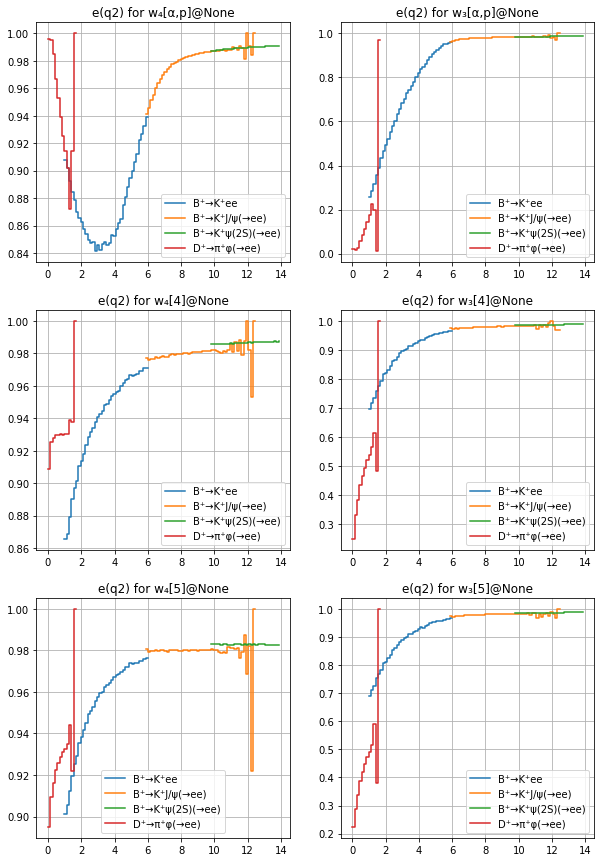

In [92]:
plot_e_all("q2", results, np.linspace(0,14,101))

In [93]:
plot_e_all("angle_ee", results, np.linspace(0,0.5,101))

### Blur

In [ ]:
def blur(w, sigma, step=0.01):
    sc = w.model[0]
    
    x_min, y_min = sc.min
    x_max, y_max = sc.max
    
    x1, y1 = sc.transform([[x_min, y_min]])[0]
    x2, y2 = sc.transform([[x_max, y_max]])[0]
    
    xval = np.arange(x1-sigma, x2+sigma, step)
    yval = np.arange(y1-sigma, y2+sigma, step)
    v = np.asarray(np.meshgrid(xval, yval)).reshape(2,-1).transpose()
    X = sc.inverse_transform(v)
    image = as_numpy(w)(X).reshape(yval.size, xval.size)
    print(image.T.shape)
    
    import scipy.ndimage
    filtered = scipy.ndimage.gaussian_filter(image, sigma=sigma/step)
    
    import scipy.interpolate
    inter = scipy.interpolate.interp2d(xval, yval, filtered)
    
    return lambda v : np.asarray([inter(x,y) for x, y in sc.transform(v)])

In [ ]:
m = results[None,"₄[α,p]"]
f00 = as_numpy(m.model)
f0 = blur(m, sigma=0.0, step=0.01)
f1 = blur(m, sigma=0.1, step=0.01)
f2 = blur(m, sigma=0.2, step=0.01)
f4 = blur(m, sigma=0.4, step=0.01)

In [ ]:
plot_field(f00, m.model[0], name="no blur")
plot_field(f0, m.model[0], name="sigma=0")
plot_field(f1, m.model[0], name="sigma=0.1")
plot_field(f2, m.model[0], name="sigma=0.2")
plot_field(f4, m.model[0], name="sigma=0.4")

In [ ]:
def quality_np(datasets, scaler, estimators, refname, name):
    df_w = pd.DataFrame()
    df_w.columns.name = name
    for i, w in enumerate(estimators):
        name1 = "w%s" % i
        r_name = "R%s" % i
        df_w[name1] = None
        for s in datasets:
            ds = Dataset(scaler.features, [s], aliases, name)
            x = to_numpy(ds.X())
            wd = w(x)
            df_w.loc[s.name(),name1] = 1-np.mean(wd).item()
        df_w[r_name] = df_w.loc[refname,name1] / df_w[name1]
    return df_w

In [ ]:
quality_np(train_ds, m.model[0], [f00,f0,f1,f2,f4], channel_names[1], "train")